# init

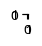

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline
import itertools 

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

In [242]:
mcs = []
cols_ = ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point',
         'dissimilarity_score',
         'blsm_mut_score', 'ratio_rank', 'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM']

for L in range(0, len(cols_) + 1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))

In [253]:
xd = ['-'.join(x) for x in mcs]

In [255]:
xd.index('aliphatic_index-boman-blsm_mut_score-EL_rank_wt_aligned-foreignness_score-Total_Gene_TPM')

706

# init

In [86]:
DIR = '../output/230427_FINAL_ANALYSIS_ALL/'

## reloading datasets

In [2]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

Peptide   wild_type        HLA  agg_label  mut_len  wt_len seq_id  \
0   AFGSAHLFR   AFGSAHLYR  HLA-A3101          1        9       9  seq_1   
1   AIANRIKFK   AIANRIKSK  HLA-A1101          0        9       9  seq_4   
2   AICKPLHYV   AICKPLHYM  HLA-A0201          0        9       9  seq_5   
3  AIPAMVVPNV  AIPAMVVPNA  HLA-A0201          0       10      10  seq_6   
4  ALEVLQSIPY  APEVLQSIPY  HLA-A0101          0       10      10  seq_7   

   Pos_mut Peptide_mut   core_mut  ... core_blsm_mut_score  aliphatic_index  \
0        0   AFGSAHLFR  AFGSAHLFR  ...                   3        65.555556   
1        0   AIANRIKFK  AIANRIKFK  ...                  -2       108.888889   
2        0   AICKPLHYV  AICKPLHYV  ...                   1       130.000000   
3        0  AIPAMVVPNV  AIPAVVPNV  ...                   0       146.000000   
4        0  ALEVLQSIPY  ALEVLQSIY  ...                  -3       156.000000   

      boman hydrophobicity isoelectric_point     VHSE1     VHSE3     VHSE7  \
0  0.837778       0.455556         10.551759  0.214444 -0.278889  0.193333   
1  1.802222      -0.044444         11.823055 -0.048889  0.125556  0.484444   
2 -0.735556       0.755556          8.530526  0.327778  0.046667 -0.017778   
3 -1.637000       1.590000          6.100000  0.431000 -0.385000 -0.067000   
4 -0.472000       0.740000          3.849983  0.292000 -0.062000 -0.096000   

      VHSE8  trueHLA_EL_rank  
0 -0.192222           0.2470  
1 -0.125556           0.1380  
2  0.263333           0.3610  
3  0.446000           2.2606  
4  0.088000           0.6230  

[5 rows x 39 columns]

In [3]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [4]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230308_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230308_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230308_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230308_nepdb_aligned_icore.csv')

In [5]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230418_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230418_nepdb_aligned_pepx.csv')

In [6]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

# Masking threshold detour

In [205]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
# DEFINING KWARGS
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': True,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'seq_col': 'icore_mut',
                   'rank_col': 'EL_rank_mut',
                   'hla_col': 'HLA',
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}

ics_kl = pkl_load('../data/ic_dicts/ics_kl_new.pkl')
conditions_list = {'Inverted-Shannon': (True, 'Inverted-Shannon', ics_shannon, False),
                       'None': (False, 'None', None, False),
                       'Mask': (False, 'Mask', ics_shannon, True),
                       'Shannon': (False, 'Shannon', ics_shannon, False),
                       'Inverted-Mask': (True, 'Inverted-Mask', ics_shannon, True),
                       'KL': (False, 'KL', ics_kl, False),
                       'Inverted-KL': (True, 'KL', ics_kl, False),
                       'KL-Mask':(False, 'KL-Mask', ics_kl, True),
                       'Inverted-KL-Mask':(True, 'Inverted-KL-Mask', ics_kl, True)}


invert, ic_name, ics_dict, mask = conditions_list['KL-Mask']
# megaloops for encoding-weighting

encoding_kwargs['encoding'] = 'onehot'
encoding_kwargs['blosum_matrix'] = None
# Doing only Inverted Shannon, Mask, None

encoding_kwargs['invert'] = invert
encoding_kwargs['mask'] = mask

xd=[]
for threshold in np.linspace(0.12,0.3, 50):
    # Using the same model and hyperparameters
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                   max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('Training')
    encoding_kwargs['threshold']=threshold
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    for evalset, evalname in zip([cedar_aligned, prime_aligned],
                                 ['CEDAR', 'PRIME']):
        # FULLY FILTERED + Mean_pred
        if not evalset.equals(cedar_aligned):
            evalset = evalset.query('Peptide not in @cedar_aligned.Peptide.values')
        _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide', 'HLA', 'agg_label']),
                                                   trained_models, ics_dict,
                                                   cedar_aligned,
                                                   encoding_kwargs, concatenated=False,
                                                   only_concat=True, n_jobs=8)        
        pcol = 'pred' if 'pred' in preds.columns else 'mean_pred'
        bootstrapped_df = bootstrap_eval(preds[pcol], preds['agg_label'],10000,n_jobs=8, auc01=False, add_roc=False, reduced=True)
        bootstrapped_df['threshold'] = threshold
        bootstrapped_df['evalset']=evalname
        xd.append(bootstrapped_df)

Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [208]:
def get_expanded_input(row):
    input_col = row['core_mut'] if row['len_icore_mut']==8 else row['icore_mut']
    return input_col
cedar_aligned['expanded_input'] = cedar_aligned.apply(get_expanded_input, axis=1)
prime_aligned['expanded_input'] = prime_aligned.apply(get_expanded_input, axis=1)


In [209]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
# DEFINING KWARGS
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': True,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'seq_col': 'expanded_input',
                   'rank_col': 'EL_rank_mut',
                   'hla_col': 'HLA',
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}

conditions_list = {'Inverted-Shannon': (True, 'Inverted-Shannon', ics_shannon, False),
                       'None': (False, 'None', None, False),
                       'Mask': (False, 'Mask', ics_shannon, True),
                       'Shannon': (False, 'Shannon', ics_shannon, False),
                       'Inverted-Mask': (True, 'Inverted-Mask', ics_shannon, True),
                       'KL': (False, 'KL', ics_kl, False),
                       'Inverted-KL': (True, 'KL', ics_kl, False),
                       'KL-Mask':(False, 'KL-Mask', ics_kl, True),
                       'Inverted-KL-Mask':(True, 'Inverted-KL-Mask', ics_kl, True)}


invert, ic_name, ics_dict, mask = conditions_list['KL-Mask']
# megaloops for encoding-weighting

encoding_kwargs['encoding'] = 'onehot'
encoding_kwargs['blosum_matrix'] = None
# Doing only Inverted Shannon, Mask, None

encoding_kwargs['invert'] = invert
encoding_kwargs['mask'] = mask

xd2=[]
for threshold in tqdm(np.linspace(0.12,0.3, 50)):
    # Using the same model and hyperparameters
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                   max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('Training')
    encoding_kwargs['threshold']=threshold
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    for evalset, evalname in zip([cedar_aligned, prime_aligned],
                                 ['CEDAR', 'PRIME']):
        # FULLY FILTERED + Mean_pred
        if not evalset.equals(cedar_aligned):
            evalset = evalset.query('Peptide not in @cedar_aligned.Peptide.values')
        _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide', 'HLA', 'agg_label']),
                                                   trained_models, ics_dict,
                                                   cedar_aligned,
                                                   encoding_kwargs, concatenated=False,
                                                   only_concat=True, n_jobs=8)        
        pcol = 'pred' if 'pred' in preds.columns else 'mean_pred'
        bootstrapped_df = bootstrap_eval(preds[pcol], preds['agg_label'],10000,n_jobs=8, auc01=False, add_roc=False, reduced=True)
        bootstrapped_df['threshold'] = threshold
        bootstrapped_df['evalset']=evalname
        xd2.append(bootstrapped_df)

  0%|          | 0/50 [00:00<?, ?it/s]

Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [211]:
z = pd.concat(xd).assign(input_type='icore')
y = pd.concat(xd2).assign(input_type='expanded8mers')


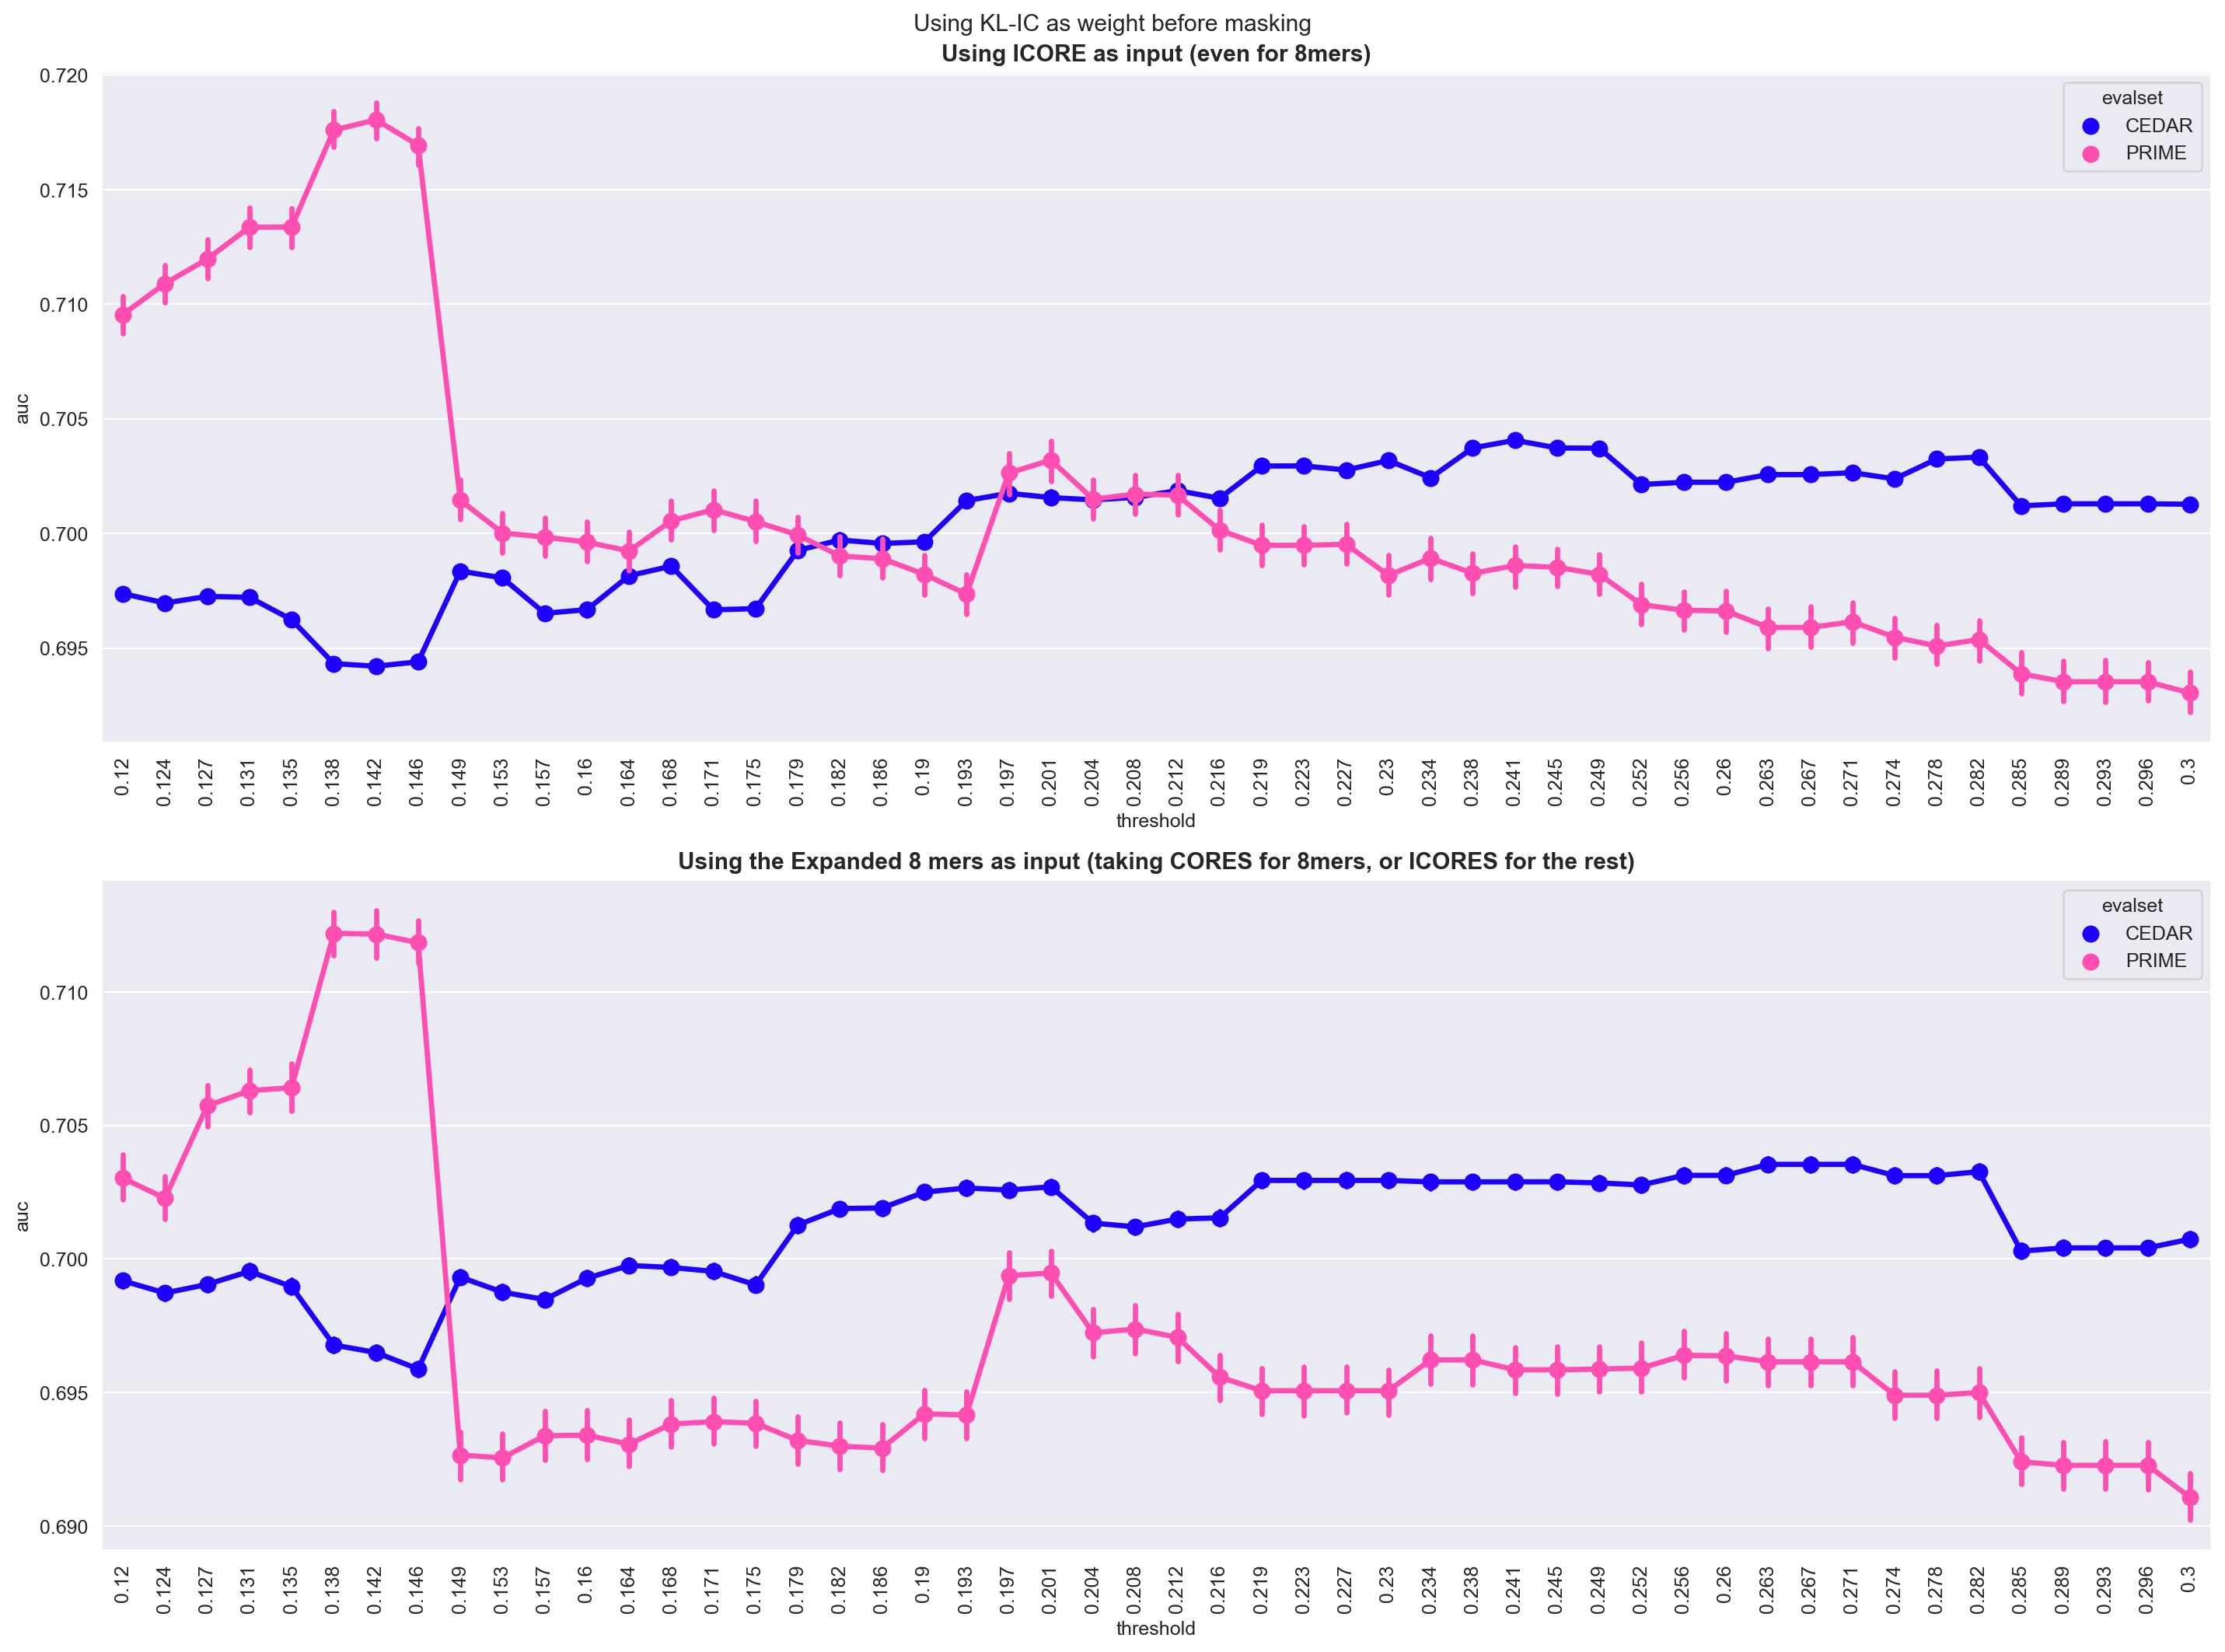

In [215]:
f,a = plt.subplots(2,1, figsize=(16,12))

a = a.ravel()
sns.set_palette(get_palette('gnuplot2', 2))
sns.pointplot(data=z, hue = 'evalset', x='threshold', y='auc', ax=a[0])
a[0].set_xticklabels([round(float(str(x)[str(x).find('\'')+1:str(x).rfind('\'')]),3)\
                   for x in a[0].get_xticklabels()], rotation=90)


sns.pointplot(data=y, hue = 'evalset', x='threshold', y='auc', ax=a[1])
a[1].set_xticklabels([round(float(str(x)[str(x).find('\'')+1:str(x).rfind('\'')]),3)\
                   for x in a[1].get_xticklabels()], rotation=90)

a[0].set_title('Using ICORE as input (even for 8mers)', fontweight='semibold')


a[1].set_title('Using the Expanded 8 mers as input (taking CORES for 8mers, or ICORES for the rest)', fontweight='semibold')
f.suptitle('Using KL-IC as weight before masking')
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/230501_MASKINGTHRESHOLD_KL_IC.png', 
          bbox_inches='tight', dpi=200)

In [386]:
for h in ics_shannon[9].keys():
    print('\n',h, '\n', [round(x,4) for x in ics_shannon[9][h][0.25]])


 HLA-A0101 
 [0.0448, 0.3621, 0.209, 0.0588, 0.0406, 0.0453, 0.0516, 0.0584, 0.8584]

 HLA-A0201 
 [0.1177, 0.6666, 0.0787, 0.1619, 0.042, 0.1222, 0.0667, 0.0758, 0.5667]

 HLA-A0202 
 [0.1107, 0.6749, 0.0607, 0.1663, 0.0499, 0.1034, 0.0567, 0.0816, 0.5931]

 HLA-A0203 
 [0.1205, 0.6533, 0.0629, 0.154, 0.0446, 0.1388, 0.0619, 0.0851, 0.5473]

 HLA-A0205 
 [0.1177, 0.4183, 0.0784, 0.2199, 0.0526, 0.1366, 0.0625, 0.0938, 0.5813]

 HLA-A0206 
 [0.1219, 0.4158, 0.0961, 0.2046, 0.0453, 0.1528, 0.0716, 0.0874, 0.5567]

 HLA-A0210 
 [0.1153, 0.4406, 0.0971, 0.1912, 0.0457, 0.1423, 0.0707, 0.0841, 0.5704]

 HLA-A0211 
 [0.1186, 0.6794, 0.0698, 0.1394, 0.0427, 0.1175, 0.0598, 0.0737, 0.5808]

 HLA-A0224 
 [0.1177, 0.6666, 0.0787, 0.1619, 0.042, 0.1222, 0.0667, 0.0758, 0.5667]

 HLA-A0301 
 [0.2145, 0.3914, 0.0682, 0.069, 0.0544, 0.0727, 0.0946, 0.0628, 0.8189]

 HLA-A0302 
 [0.1959, 0.393, 0.0628, 0.0716, 0.0546, 0.0665, 0.0788, 0.0648, 0.8311]

 HLA-A1101 
 [0.1842, 0.3793, 0.0737, 0.074, 0.0

# Input analysis (Fig 3,4)

In [220]:
input_df = pd.read_csv('../output/230427_FINAL_ANALYSIS_ALL/230501_input_weight_comparison_newKL.csv')
bdfs2 = pd.read_csv('../output/230427_FINAL_ANALYSIS_ALL/input_df_comparison_prime_threshold_03.csv')

## results figs

In [229]:
print(input_df.weight.unique())
weight_order = ['Inverted Shannon', 'Inverted-KL', 'Inverted Mask', 'Inverted-KL-Mask',
                'None',
                'Shannon', 'KL', 'Mask', 'KL-Mask']

['Inverted Shannon' 'Inverted Mask' 'None' 'Mask' 'Shannon' 'Inverted-KL'
 'Inverted-KL-Mask' 'KL-Mask' 'KL']


0.0
0.0
0.0
9.999999999998899e-05


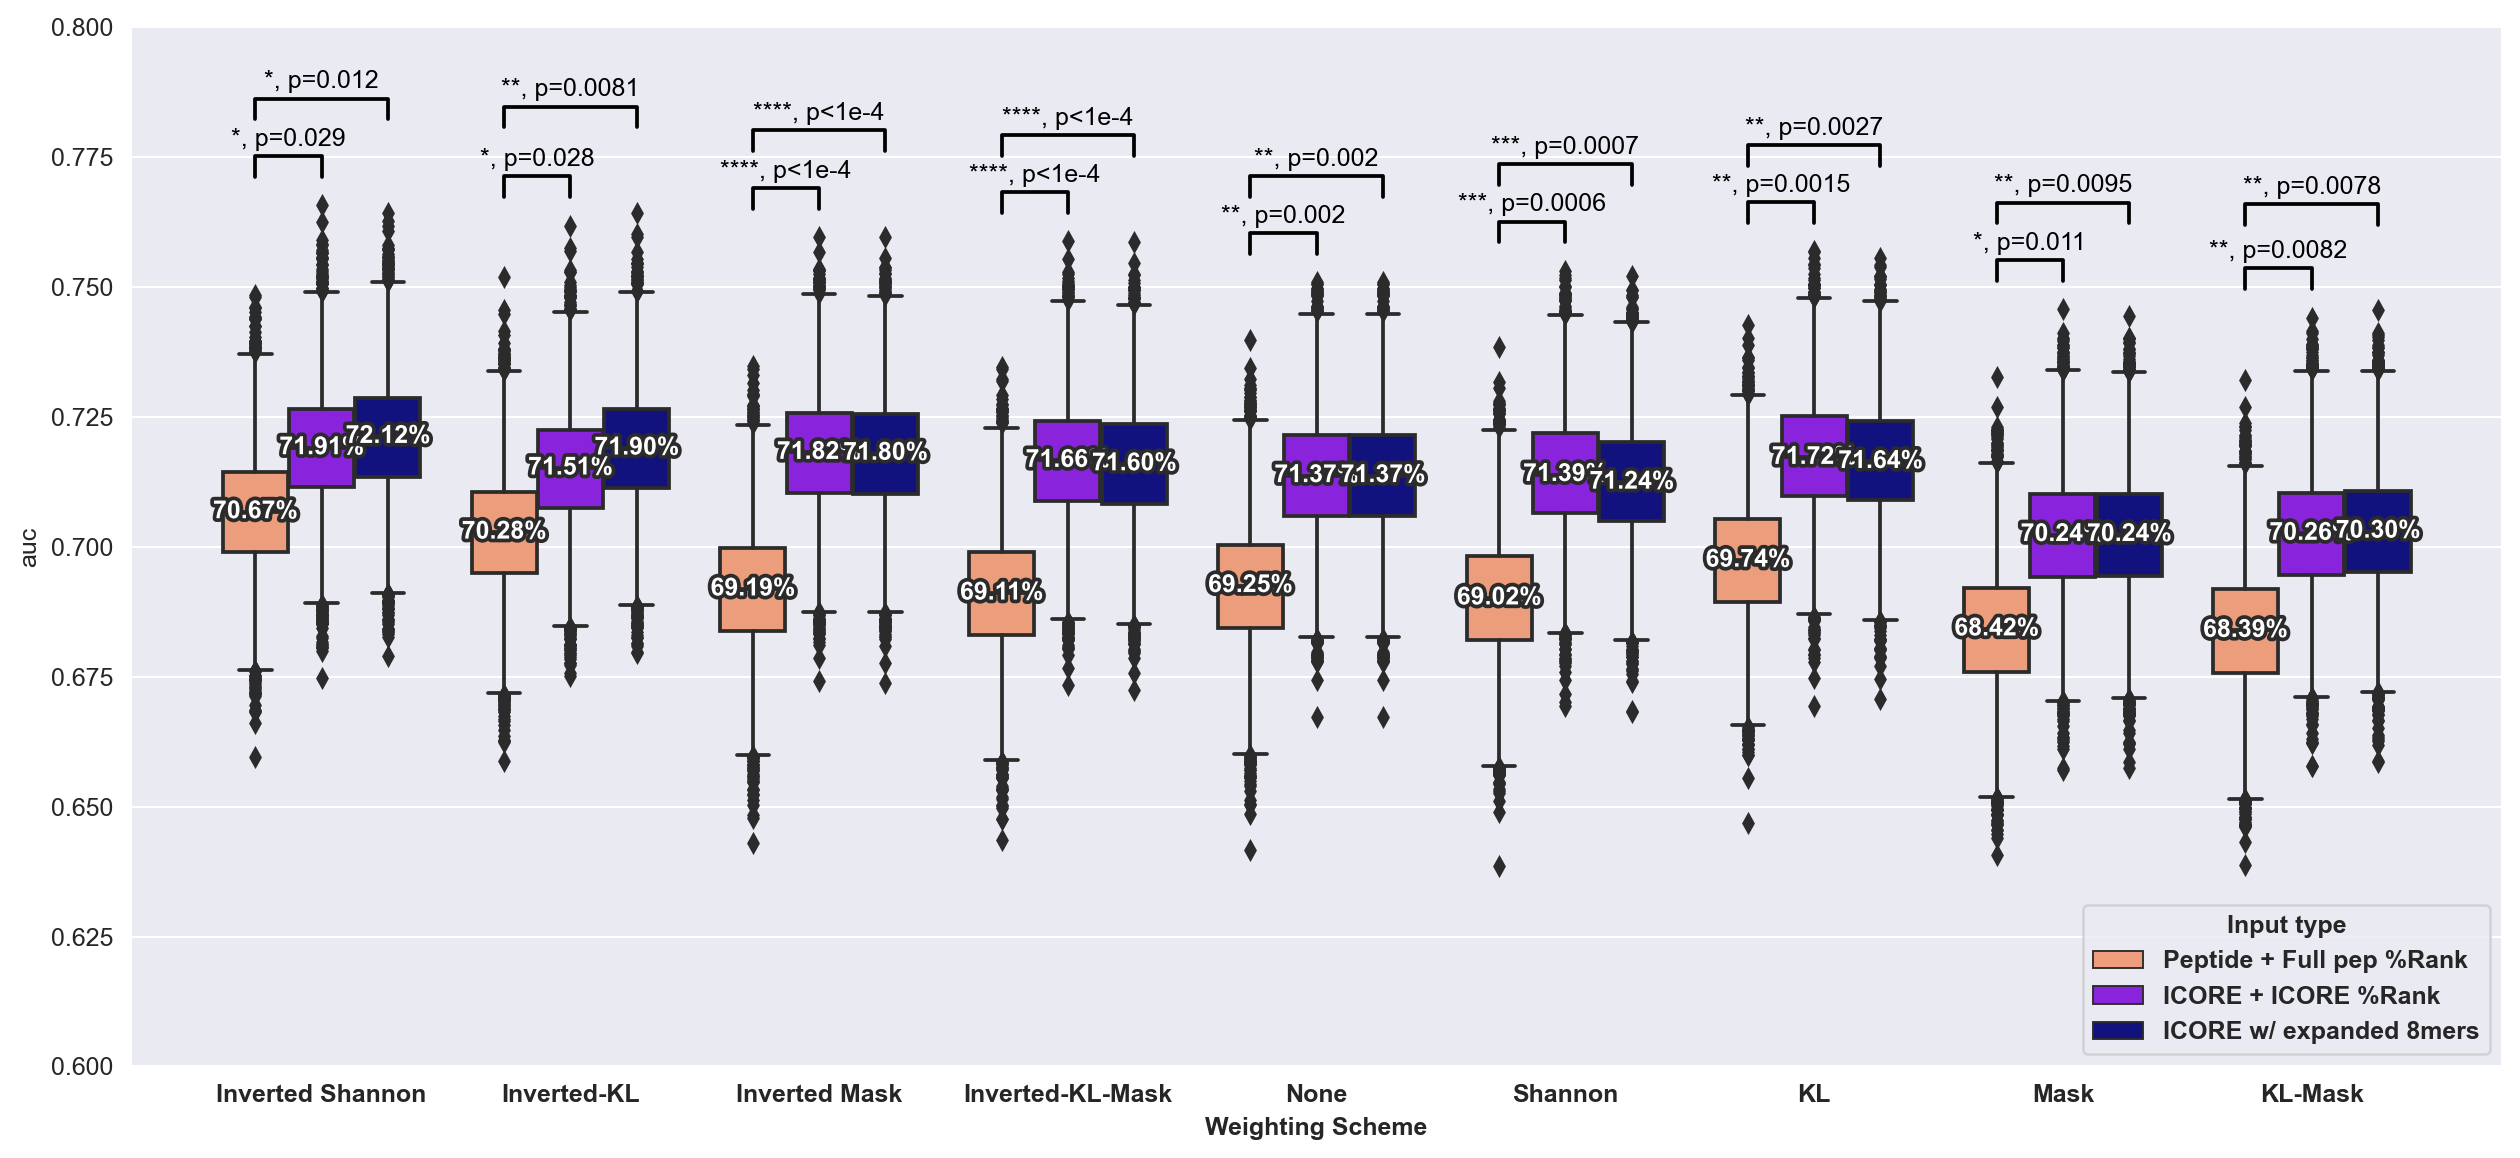

In [230]:
from src.bootstrap import get_pval_wrapper
f,a = plt.subplots(1,1, figsize=(17,7.5))
# weight_order = ['Inverted Shannon', 'Inverted Mask', 'None', 'Mask', 'Shannon']
sns.boxplot(data=input_df.query('evalset=="CEDAR"').replace({'Peptide':'Peptide + Full pep %Rank',
                                                             'icore_mut':'ICORE + ICORE %Rank',
                                                             'expanded_input':'ICORE w/ expanded 8mers'}), 
            hue= 'input_type', y='auc', x = 'weight', order=weight_order, 
            palette=get_palette('gnuplot2_r', n_colors=3))
# a.set_title('Inputs comparison, bootstrapped crossvalidation AUCs for CEDAR', fontweight = 'semibold', fontsize=14)
add_median_labels(a, fmt='.2%')

# pvals
for weight in weight_order:
    x0 = weight_order.index(weight)
    x1,x2,x3 = x0-(0.8/3), x0, x0+(0.8/3)
    
    aucs_pep = input_df.query('evalset=="CEDAR" and weight==@weight and input_type=="Peptide"').auc.values#.sort_values('seed').auc.values
    aucs_icore = input_df.query('evalset=="CEDAR" and weight==@weight and input_type=="icore_mut"').auc.values#.sort_values('seed').auc.values
    aucs_exp = input_df.query('evalset=="CEDAR" and weight==@weight and input_type=="expanded_input"').auc.values#.sort_values('seed').auc.values
    h = 0.0055
    y0 = max(aucs_icore)+h
    y1 = max(max(aucs_icore), max(aucs_exp)) + 3*h
    
    # Pep vs ICORE
    pval, sig = get_pval_wrapper(input_df.query("evalset=='CEDAR' and weight==@weight and input_type=='icore_mut'"), 
                                 input_df.query("evalset=='CEDAR' and weight==@weight and input_type == 'Peptide'"),
                                 'auc')
    plot_pval(a, pval, sig, x1, x2, y = y0, h=0.005)
    
    # Pep vs Expanded
    pval, sig = get_pval_wrapper(input_df.query("evalset=='CEDAR' and weight==@weight and input_type=='expanded_input'"), 
                                 input_df.query("evalset=='CEDAR' and weight==@weight and input_type == 'Peptide'"),
                                 'auc')
    plot_pval(a, pval, sig, x1, x3, y = y1, h=0.005)
a.set_xticklabels(a.get_xticklabels(), fontweight='semibold')
a.set_xlabel('Weighting Scheme', fontweight='semibold')
a.set_ylim([0.6,0.8])
a.legend(loc='lower right', title='Input type', prop=dict(weight='semibold'), title_fontproperties=dict(weight='semibold'))
f.savefig('../../../writing/230131_cedar_paper_1/figures/230428_input_comparisons_pvals.png', dpi=200, bbox_inches='tight')

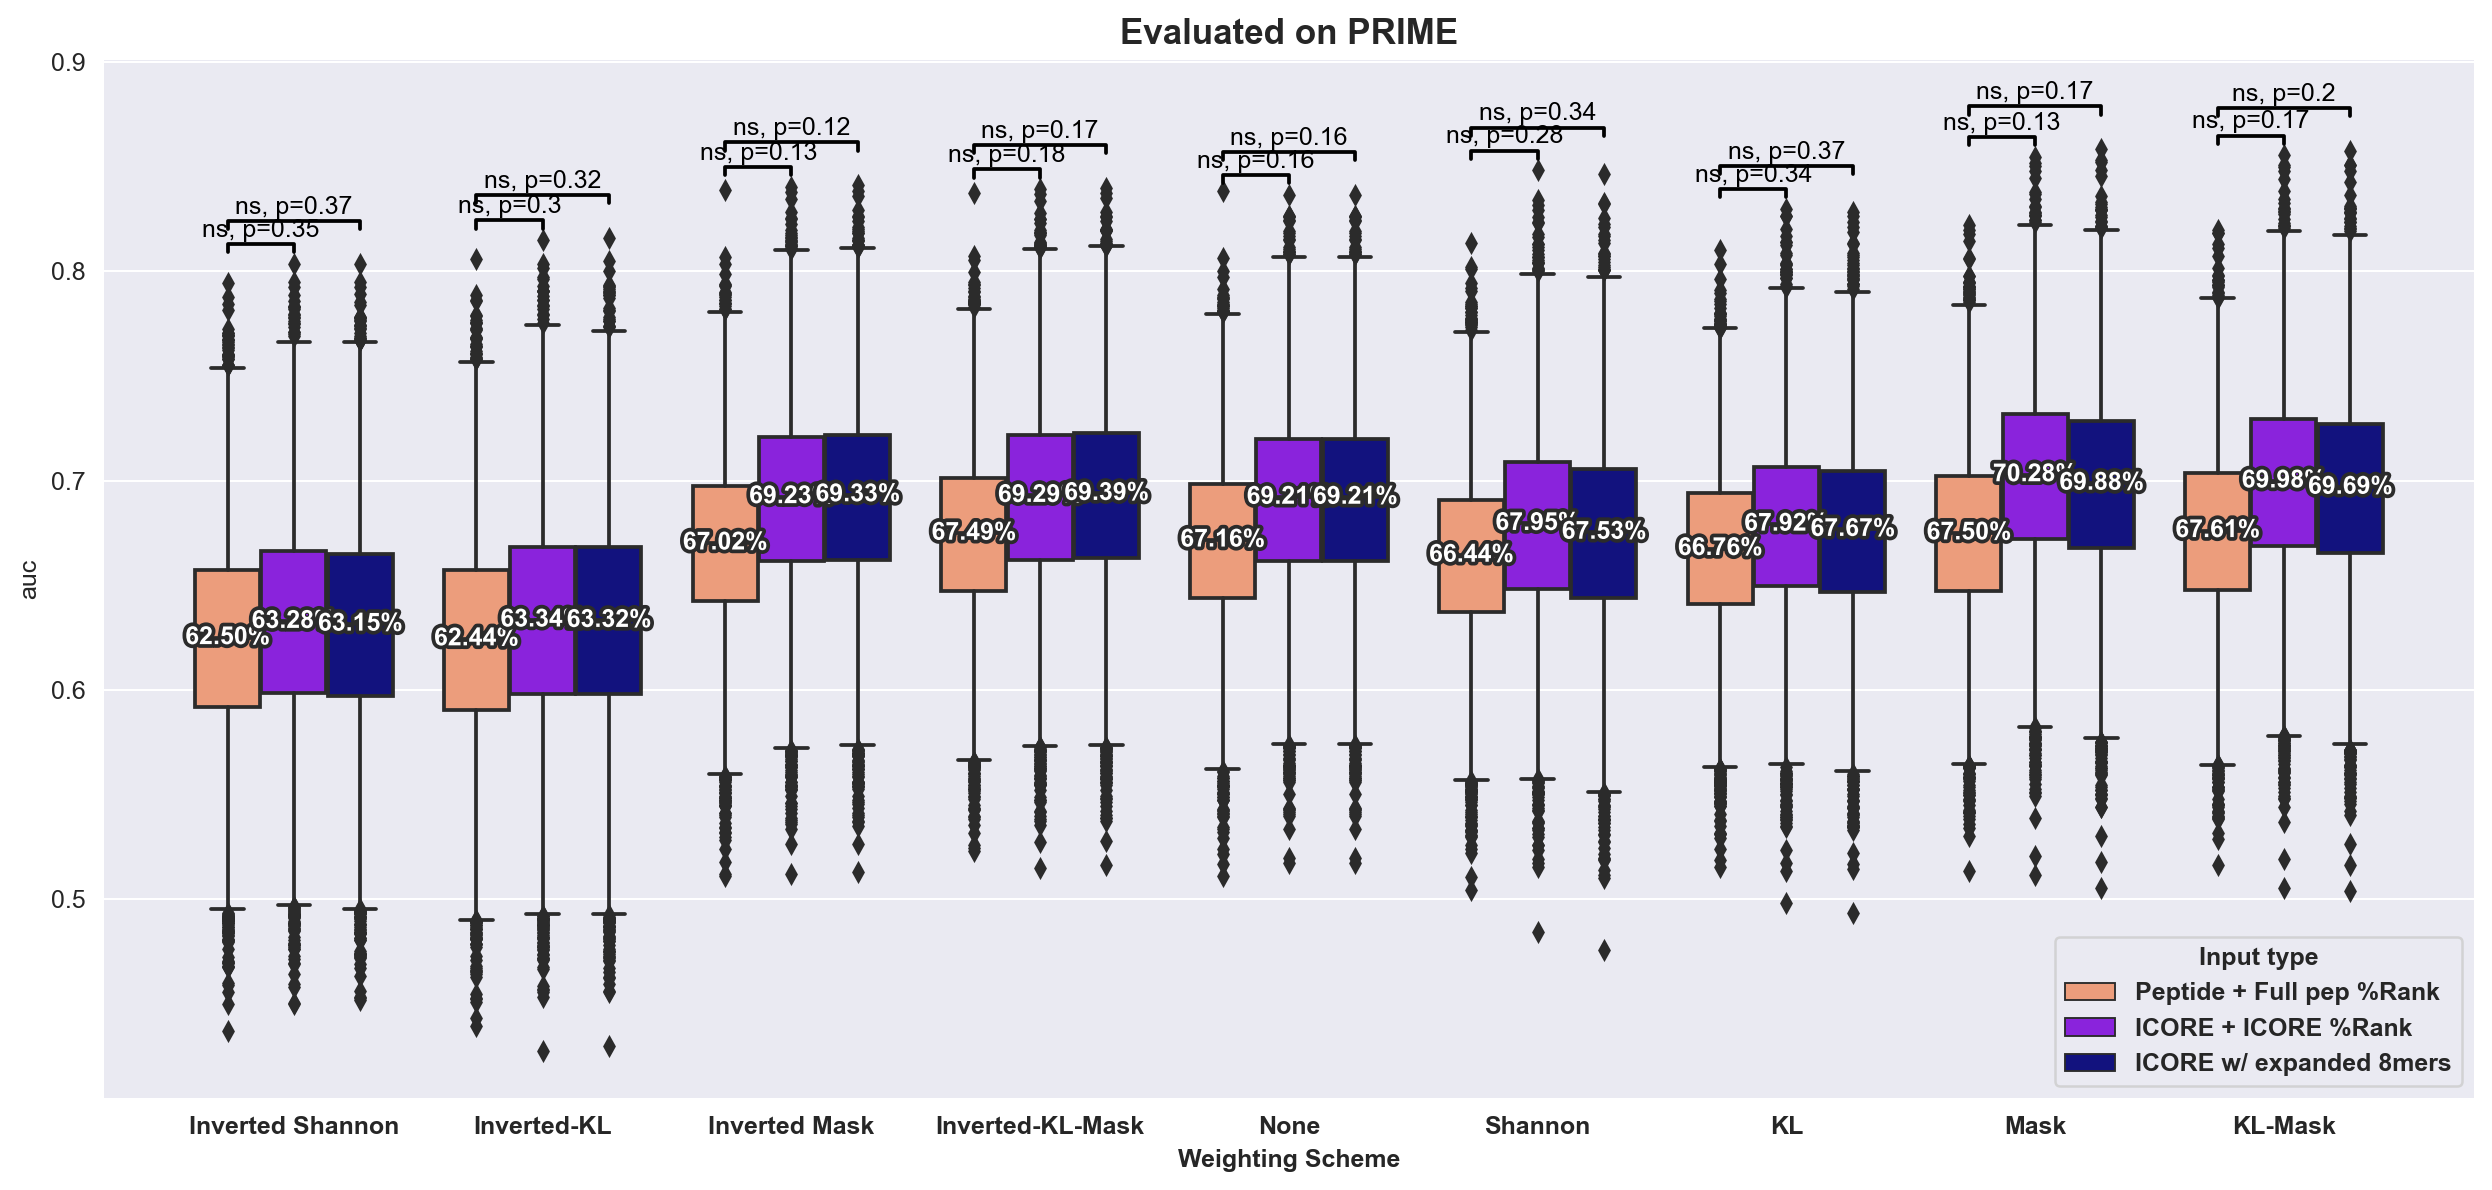

In [366]:
from src.bootstrap import get_pval_wrapper
f,a = plt.subplots(1,1, figsize=(17,7.5))
# weight_order = ['Inverted Shannon', 'Inverted Mask', 'None', 'Mask', 'Shannon']
sns.boxplot(data=input_df.query('evalset=="PRIME"').replace({'Peptide':'Peptide + Full pep %Rank',
                                                             'icore_mut':'ICORE + ICORE %Rank',
                                                             'expanded_input':'ICORE w/ expanded 8mers'}), 
            hue= 'input_type', y='auc', x = 'weight', order=weight_order, 
            palette=get_palette('gnuplot2_r', n_colors=3))
# a.set_title('Inputs comparison, bootstrapped crossvalidation AUCs for CEDAR', fontweight = 'semibold', fontsize=14)
add_median_labels(a, fmt='.2%')

# pvals
for weight in weight_order:
    x0 = weight_order.index(weight)
    x1,x2,x3 = x0-(0.8/3), x0, x0+(0.8/3)
    
    aucs_pep = input_df.query('evalset=="PRIME" and weight==@weight and input_type=="Peptide"').auc.values#.sort_values('seed').auc.values
    aucs_icore = input_df.query('evalset=="PRIME" and weight==@weight and input_type=="icore_mut"').auc.values#.sort_values('seed').auc.values
    aucs_exp = input_df.query('evalset=="PRIME" and weight==@weight and input_type=="expanded_input"').auc.values#.sort_values('seed').auc.values
    h = 0.0055
    y0 = max(aucs_icore)+h
    y1 = max(max(aucs_icore), max(aucs_exp)) + 3*h
    
    # Pep vs PRIME
    pval, sig = get_pval_wrapper(input_df.query("evalset=='PRIME' and weight==@weight and input_type=='icore_mut'"), 
                                 input_df.query("evalset=='PRIME' and weight==@weight and input_type == 'Peptide'"),
                                 'auc')
    plot_pval(a, pval, sig, x1, x2, y = y0, h=0.005)
    
    # Pep vs Expanded
    pval, sig = get_pval_wrapper(input_df.query("evalset=='PRIME' and weight==@weight and input_type=='expanded_input'"), 
                                 input_df.query("evalset=='PRIME' and weight==@weight and input_type == 'Peptide'"),
                                 'auc')
    plot_pval(a, pval, sig, x1, x3, y = y1, h=0.005)
a.set_xticklabels(a.get_xticklabels(), fontweight='semibold')
a.set_title('Evaluated on PRIME', fontweight='semibold', fontsize=14)
a.set_xlabel('Weighting Scheme', fontweight='semibold')
# a.set_ylim([0.6,0.8])
a.legend(loc='lower right', title='Input type', prop=dict(weight='semibold'), title_fontproperties=dict(weight='semibold'))
f.savefig('../../../writing/230131_cedar_paper_1/figures/230428_input_comparisons_pvals_PRIME.png', dpi=200, bbox_inches='tight')

In [ ]:

def get_input(row):
    if row['input_type']=='Peptide':return 'Peptide + Full pep %Rank'
    if row['input_type']=='icore_mut':return 'ICORE + ICORE %Rank'
    if row['input_type']=='expanded_input':return 'ICORE w/ expanded 8mers'


0.1382 ns
0.0826 ns
0.07820000000000005 ns
0.07799999999999996 ns
0.26070000000000004 ns
0.32430000000000003 ns
0.31920000000000004 ns
0.04169999999999996 *
0.03359999999999996 *
0.16249999999999998 ns
0.0797 ns
0.06120000000000003 ns
0.33109999999999995 ns
0.39159999999999995 ns
0.3823 ns
0.05500000000000005 ns


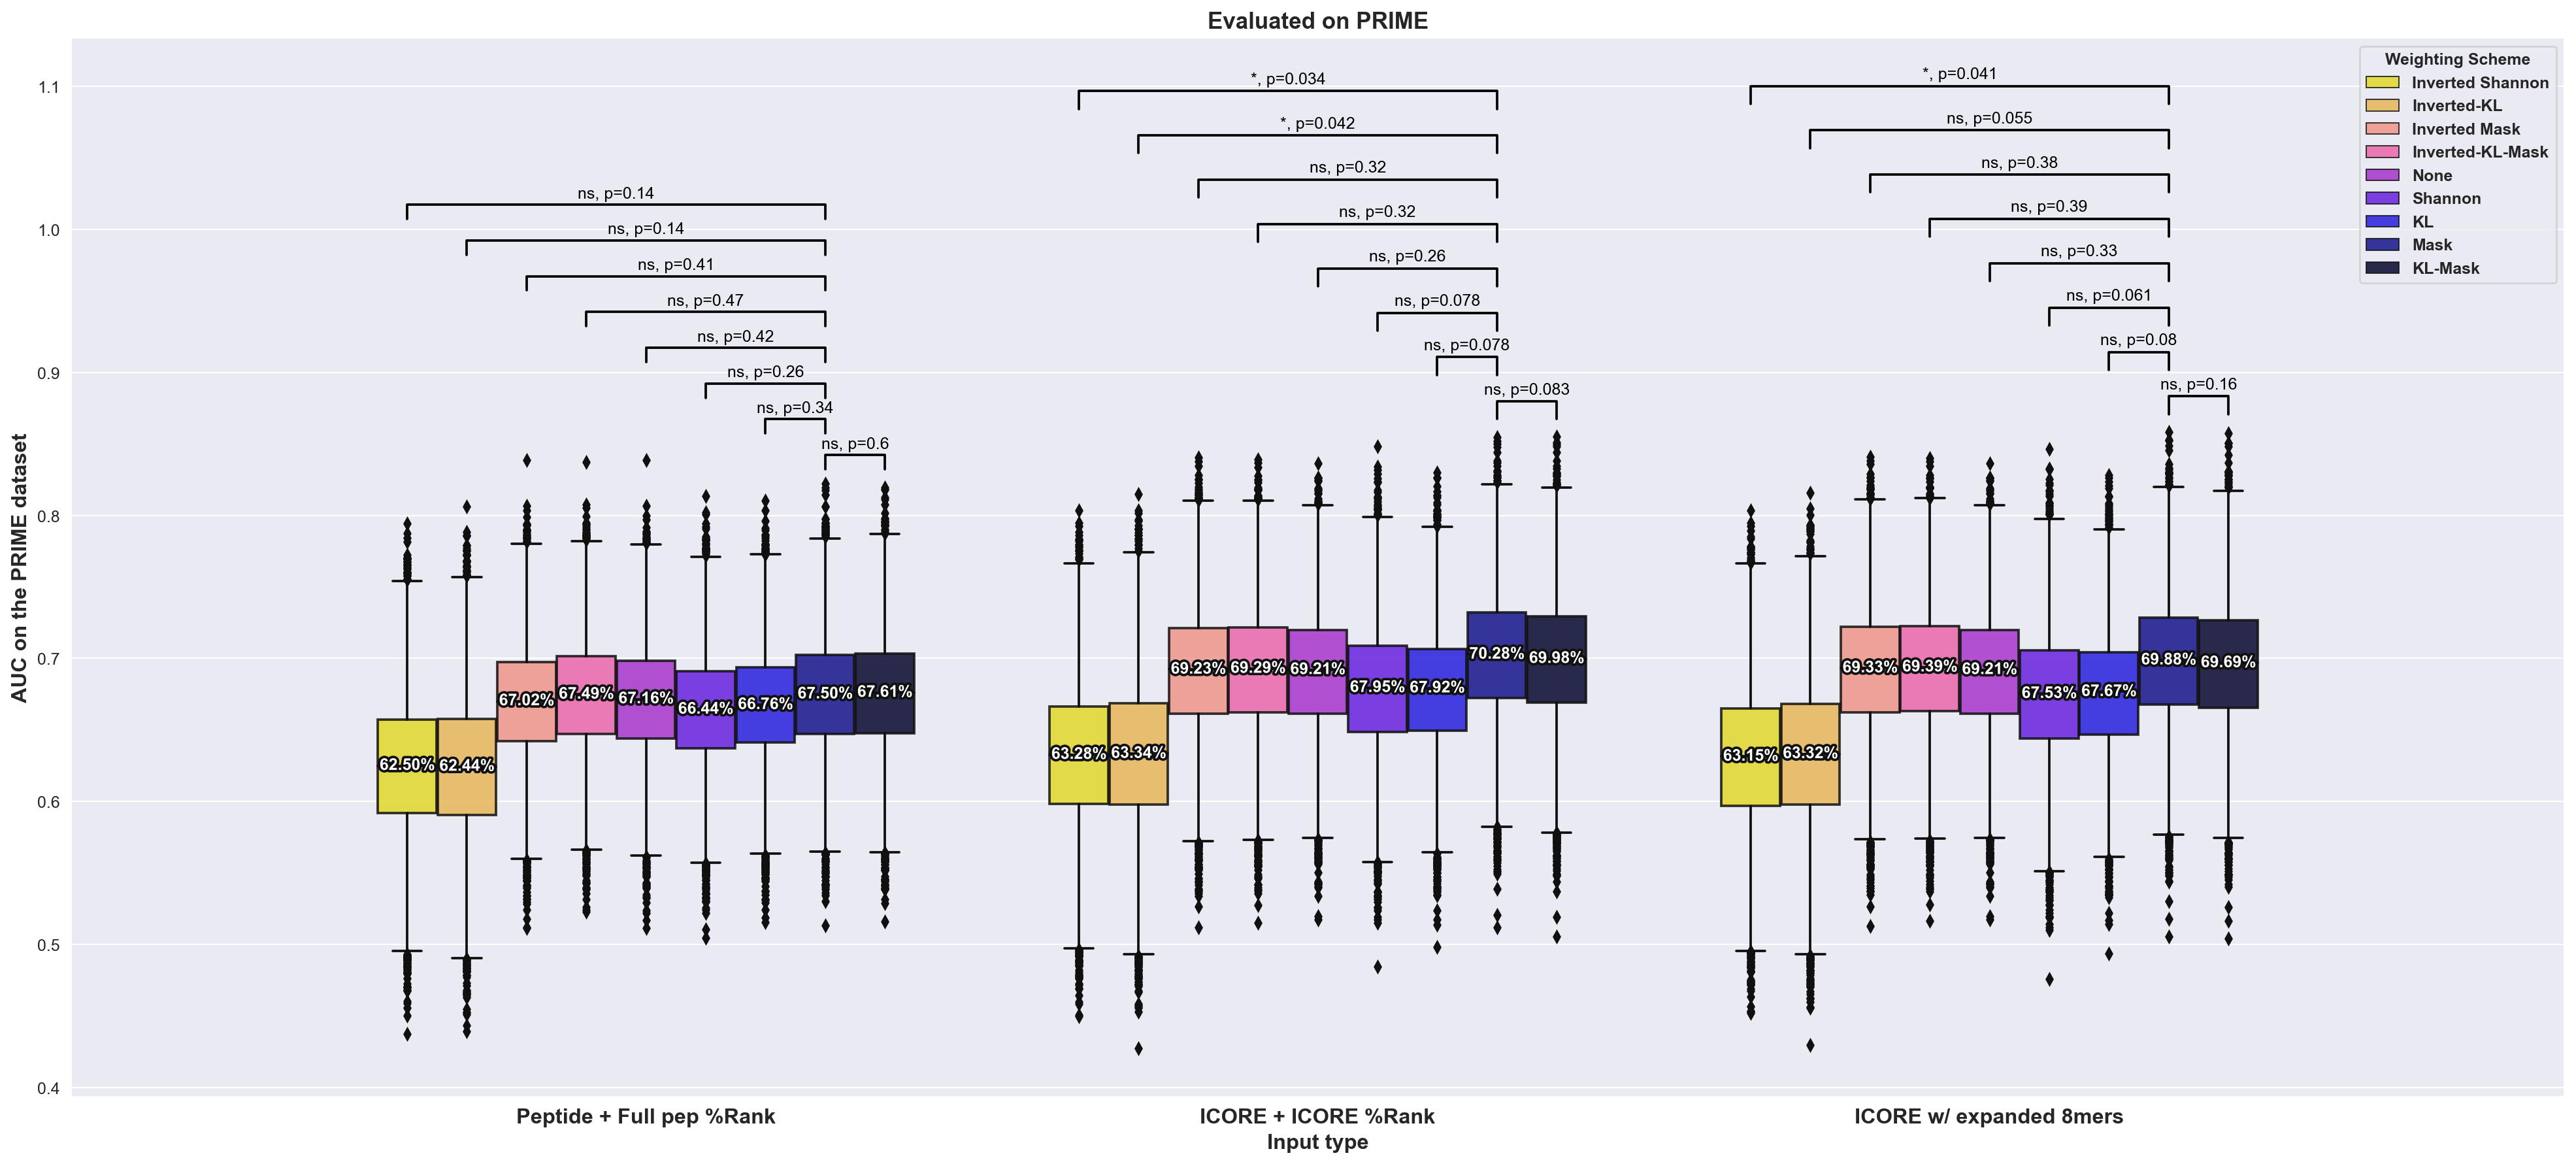

In [236]:
# Remake fig4 for PRIME

# Redo the figure here for prime only as requested
f, axis = plt.subplots(1,1, figsize=(22,10), sharex=True)
# weight_order = ['Inverted Shannon', 'Inverted Mask', 'None', 'Mask', 'Shannon']

weight_order = ['Inverted Shannon', 'Inverted-KL', 'Inverted Mask', 'Inverted-KL-Mask',
                'None',
                'Shannon', 'KL', 'Mask', 'KL-Mask']
weight_color_order = {k:v for k,v in zip(weight_order, get_palette('gnuplot2_r', n_colors=len(weight_order)))}
# for type_, axis in zip(cedar_total_df['type'].unique(), a.ravel()):


boxwidth = .8

tmp = input_df.query('evalset=="PRIME"')

tmp['type']=tmp.apply(get_input,axis=1)
sns.boxplot(data= tmp, x='type', hue = 'weight', y = 'auc', width=boxwidth, dodge=True,
            hue_order = weight_order, palette = weight_color_order, ax=axis)
add_median_labels(axis, '.2%')

# axis.set_title(f'Input: {type_}', fontweight='semibold', fontsize=13)
axis.set_xticklabels(axis.get_xticklabels(), fontweight='semibold', fontsize=13)
axis.set_ylabel('AUC on the PRIME dataset', fontweight='semibold', fontsize=13)
plt.setp(axis.patches, alpha=0.85)

# X0 (CEDAR) pvals
dx = boxwidth/len(weight_order) # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
x0 = 0
xs = [x0-4*dx, x0-3*dx, x0-2*dx, x0-dx, 
      x0, 
      x0+dx, x0+2*dx, x0+3*dx, x0+4*dx]
x1 = xs[weight_order.index('Mask')]
h, h0 = 0.01, 0.0125
aucs_mask = tmp.query('evalset=="PRIME"  and type.str.contains("Peptide") and weight=="Mask"')

for i, comp in enumerate(reversed(list(filter(lambda x: x!='Mask', weight_order)))):
    x2 = xs[weight_order.index(comp)]
    aucs_comp = tmp.query('evalset=="PRIME" and type.str.contains("Peptide") and weight==@comp')
    pval, sig = get_pval_wrapper(aucs_mask, aucs_comp, 'auc')
    plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
    # x1+=dx
    h+=2*h0

# X1 (PRIME) pvals
dx = boxwidth/len(weight_order) # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
x0 = 1
xs = [x0-4*dx, x0-3*dx, x0-2*dx, x0-dx, 
      x0, 
      x0+dx, x0+2*dx, x0+3*dx, x0+4*dx]
x1 = xs[weight_order.index('Mask')]
h, h0 = 0.0125, 0.0155
aucs_mask = tmp.query('evalset=="PRIME" and type.str.contains("ICORE") and not type.str.contains("exp") and weight=="Mask"')
for comp in reversed(list(filter(lambda x: x!='Mask', weight_order))):
    x2 = xs[weight_order.index(comp)]
    aucs_comp = tmp.query('evalset=="PRIME" and type.str.contains("ICORE") and not type.str.contains("exp") and weight==@comp')
    print(pval, sig)
    pval, sig = get_pval_wrapper(aucs_mask, aucs_comp)
    plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
    # x1+=dx
    h+=2*h0
    
    
# X1 (PRIME) pvals
dx = boxwidth/len(weight_order) # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
x0 = 2
xs = [x0-4*dx, x0-3*dx, x0-2*dx, x0-dx, 
      x0, 
      x0+dx, x0+2*dx, x0+3*dx, x0+4*dx]
x1 = xs[weight_order.index('Mask')]
h, h0 = 0.0125, 0.0155
aucs_mask = tmp.query('evalset=="PRIME" and type.str.contains("exp") and weight=="Mask"')
for comp in reversed(list(filter(lambda x: x!='Mask', weight_order))):
    x2 = xs[weight_order.index(comp)]
    aucs_comp = tmp.query('evalset=="PRIME" and type.str.contains("exp") and weight==@comp')
    print(pval, sig)
    pval, sig = get_pval_wrapper(aucs_mask, aucs_comp)
    plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
    # x1+=dx
    h+=2*h0
        
# axis.set_ylim([.5, .925])
axis.legend(prop={'weight':'semibold'}, title='Weighting Scheme', title_fontproperties={'weight':'semibold'})
# a.set_xlabel('')
axis.set_xlabel('Input type', fontweight='semibold', fontsize=13)
axis.set_title("Evaluated on PRIME", fontweight='semibold', fontsize=14)
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/230501_XD_PRIME_ONLY_weights_comparison_newpal_pvals.png',
          bbox_inches='tight', dpi=200)

0.12870000000000004 ns
0.05679999999999996 ns
0.05410000000000004 ns
0.42579999999999996 ns
0.29469999999999996 ns
0.263 ns
0.36650000000000005 ns
0.45520000000000005 ns
0.1069 ns
0.0393 *
0.03590000000000004 *
0.30489999999999995 ns
0.17279999999999995 ns
0.18279999999999996 ns
0.23519999999999996 ns
0.32930000000000004 ns
0.1382 ns
0.0826 ns
0.07820000000000005 ns
0.07799999999999996 ns
0.26070000000000004 ns
0.32430000000000003 ns
0.31920000000000004 ns
0.04169999999999996 *
0.03359999999999996 *
0.16249999999999998 ns
0.0797 ns
0.06120000000000003 ns
0.33109999999999995 ns
0.39159999999999995 ns
0.3823 ns
0.05500000000000005 ns


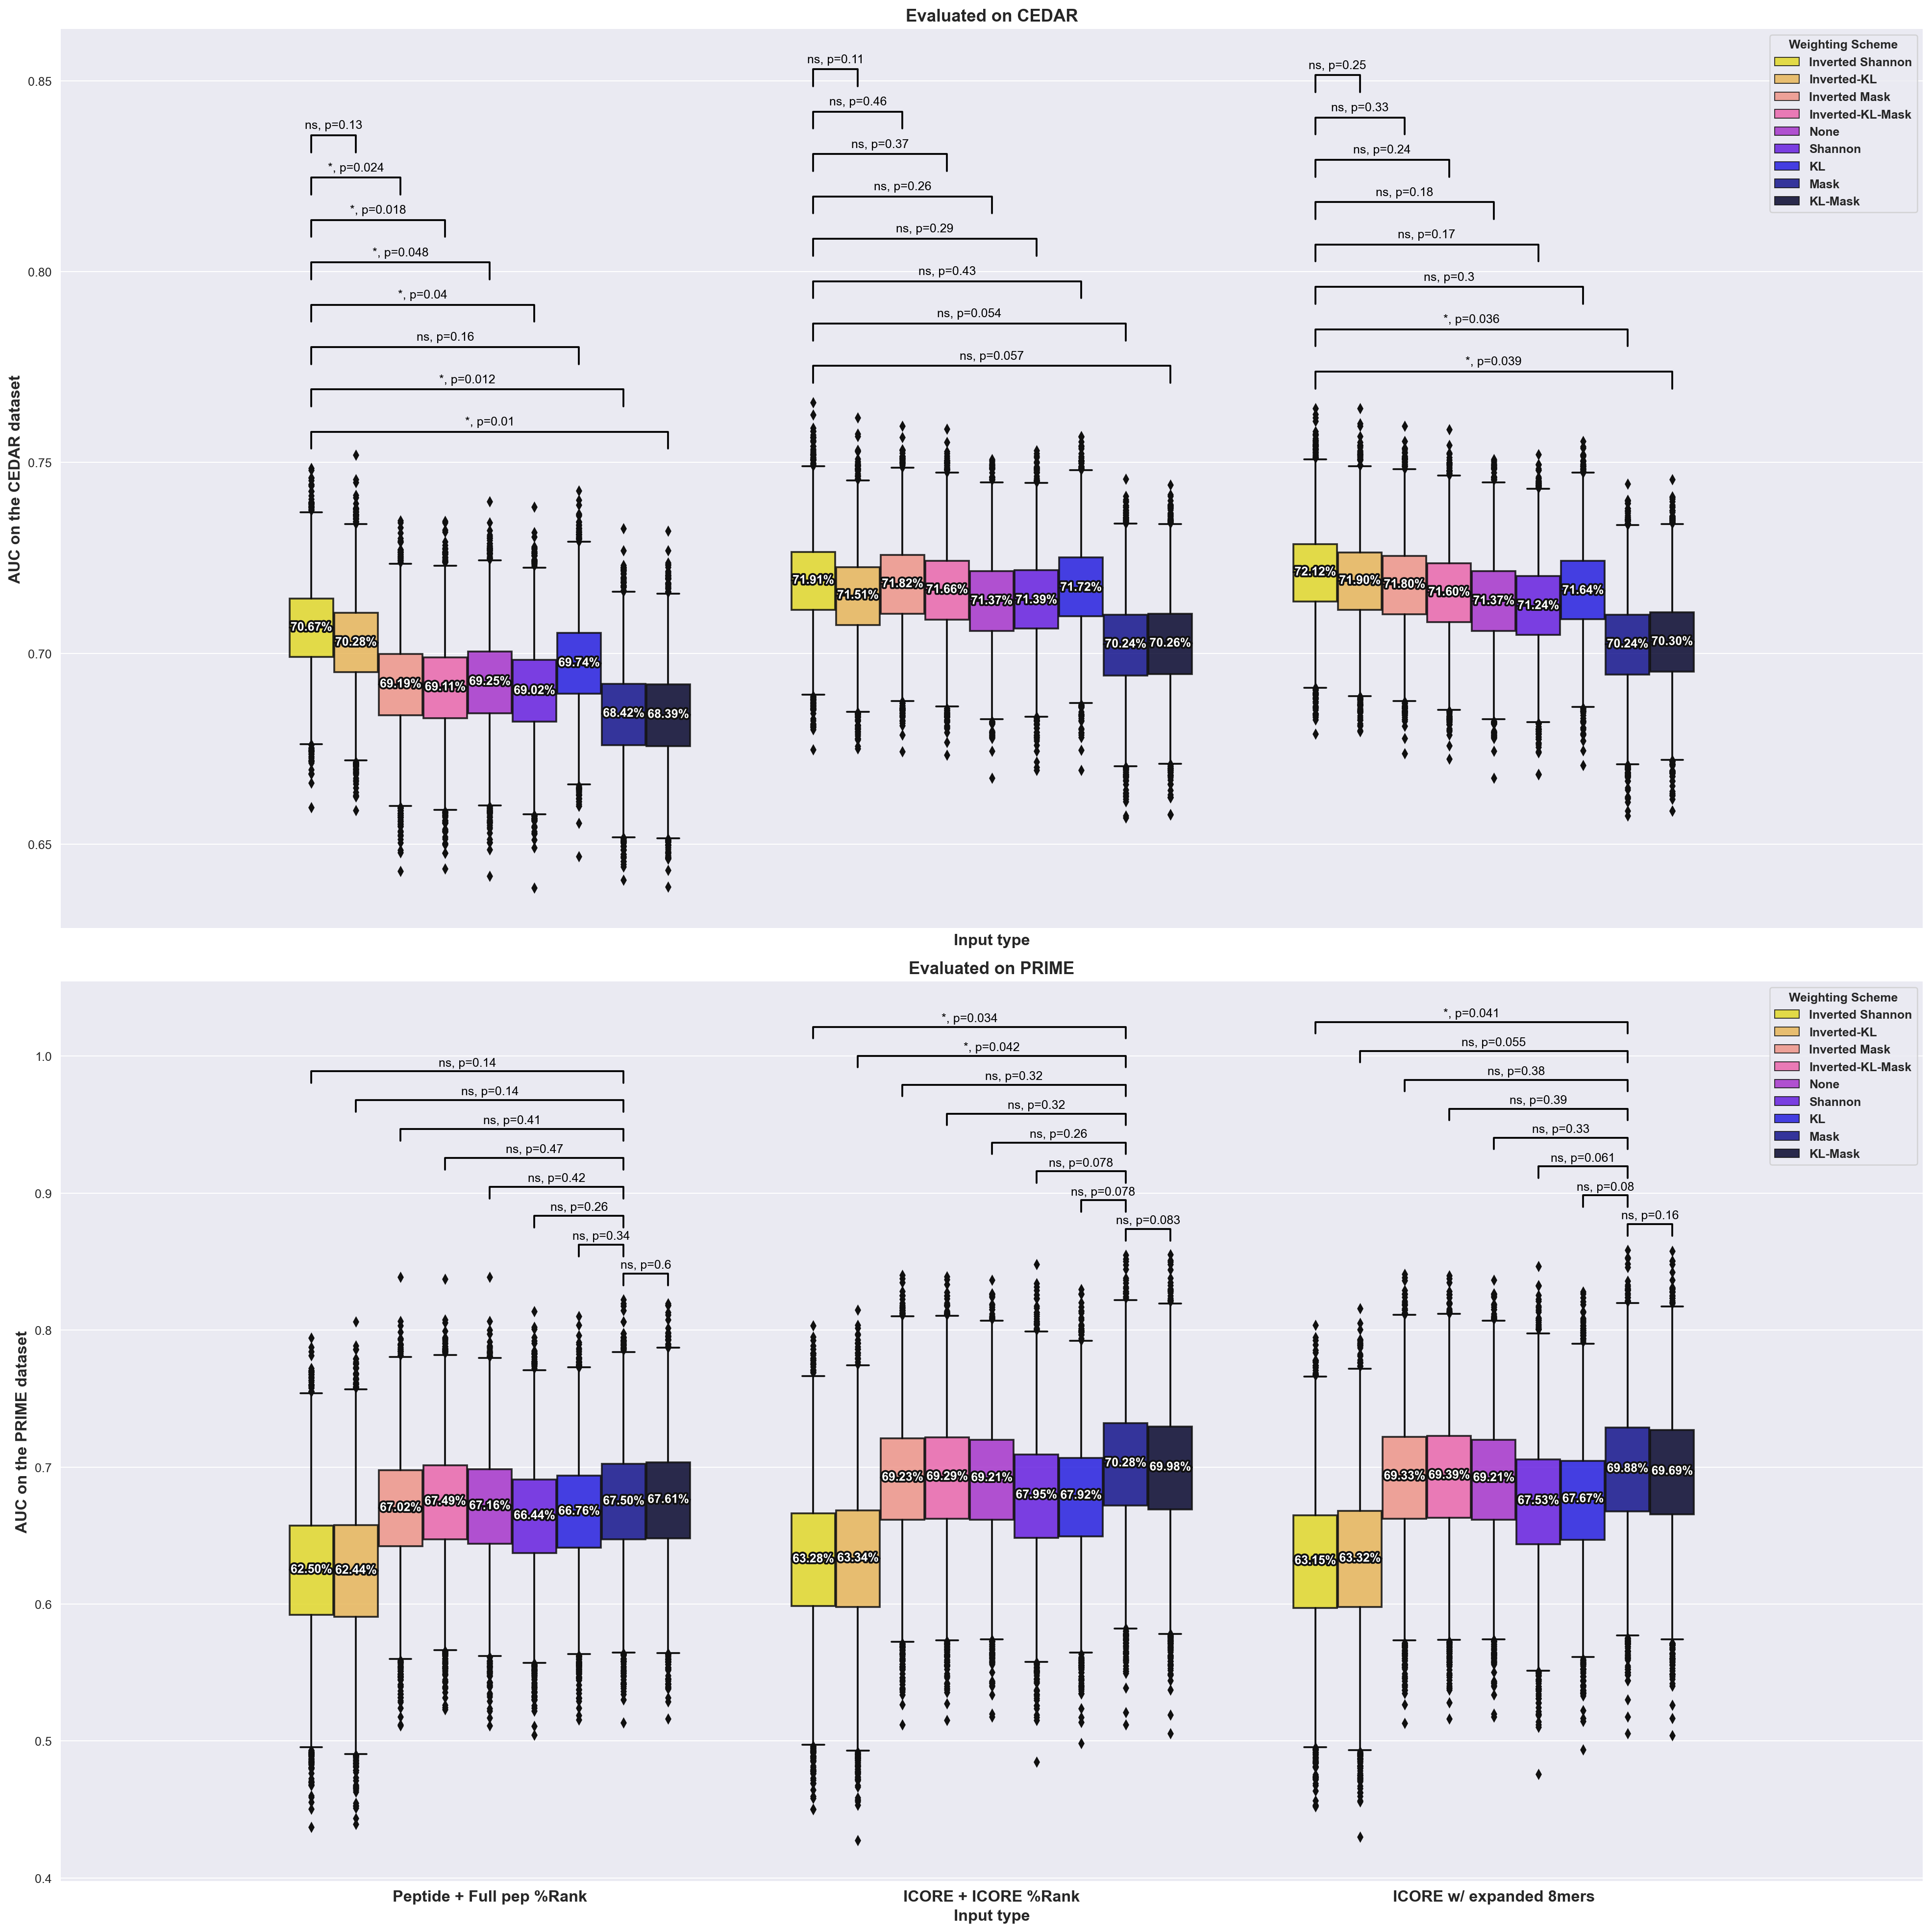

In [241]:
# Remake plot but with both evalsets :

# Remake fig4 for PRIME

weight_order = ['Inverted Shannon', 'Inverted-KL', 'Inverted Mask', 'Inverted-KL-Mask',
                'None',
                'Shannon', 'KL', 'Mask', 'KL-Mask']
weight_color_order = {k:v for k,v in zip(weight_order, get_palette('gnuplot2_r', n_colors=len(weight_order)))}
# for type_, axis in zip(cedar_total_df['type'].unique(), a.ravel()):

f,a = plt.subplots(2,1, figsize=(22, 22), sharex=True)
for evalset, axis in zip(['CEDAR', 'PRIME'],a.ravel()):
                         
    boxwidth = .8
    best = 'Mask' if evalset=="PRIME" else "Inverted Shannon"
    tmp = input_df.query('evalset==@evalset')

    tmp['type']=tmp.apply(get_input,axis=1)
    sns.boxplot(data= tmp, x='type', hue = 'weight', y = 'auc', width=boxwidth, dodge=True,
                hue_order = weight_order, palette = weight_color_order, ax=axis)
    add_median_labels(axis, '.2%')

    # axis.set_title(f'Input: {type_}', fontweight='semibold', fontsize=13)
    axis.set_xticklabels(axis.get_xticklabels(), fontweight='semibold', fontsize=13)
    axis.set_ylabel(f'AUC on the {evalset} dataset', fontweight='semibold', fontsize=13)
    plt.setp(axis.patches, alpha=0.85)

    # X0 (CEDAR) pvals
    dx = boxwidth/len(weight_order) # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
    x0 = 0
    xs = [x0-4*dx, x0-3*dx, x0-2*dx, x0-dx, 
          x0, 
          x0+dx, x0+2*dx, x0+3*dx, x0+4*dx]
    x1 = xs[weight_order.index(best)]
    if evalset=="CEDAR" :
        h, h0 = 0.005125, 0.00555 
    else: h,h0= 0.0105, 0.01055
    aucs_mask = tmp.query('evalset==@evalset  and type.str.contains("Peptide") and weight==@best')

    for i, comp in enumerate(reversed(list(filter(lambda x: x!=best, weight_order)))):
        x2 = xs[weight_order.index(comp)]
        aucs_comp = tmp.query('evalset==@evalset and type.str.contains("Peptide") and weight==@comp')
        pval, sig = get_pval_wrapper(aucs_mask, aucs_comp, 'auc')
        plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
        # x1+=dx
        h+=2*h0

    # X1 (PRIME) pvals
    dx = boxwidth/len(weight_order) # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
    x0 = 1
    xs = [x0-4*dx, x0-3*dx, x0-2*dx, x0-dx, 
          x0, 
          x0+dx, x0+2*dx, x0+3*dx, x0+4*dx]
    x1 = xs[weight_order.index(best)]
    if evalset=="CEDAR" :
        h, h0 = 0.005125, 0.00555 
    else: h,h0= 0.0105, 0.01055
                         
    aucs_mask = tmp.query('evalset==@evalset and type.str.contains("ICORE")'\
                          'and not type.str.contains("exp") and weight==@best')
    for comp in reversed(list(filter(lambda x: x!=best, weight_order))):
        x2 = xs[weight_order.index(comp)]
        aucs_comp = tmp.query('evalset==@evalset and type.str.contains("ICORE") and not type.str.contains("exp") and weight==@comp')
        print(pval, sig)
        pval, sig = get_pval_wrapper(aucs_mask, aucs_comp)
        plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
        # x1+=dx
        h+=2*h0


    # X1 (PRIME) pvals
    dx = boxwidth/len(weight_order) # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
    x0 = 2
    xs = [x0-4*dx, x0-3*dx, x0-2*dx, x0-dx, 
          x0, 
          x0+dx, x0+2*dx, x0+3*dx, x0+4*dx]
    x1 = xs[weight_order.index(best)]
    if evalset=="CEDAR" :
        h, h0 = 0.005125, 0.00555 
    else: h,h0= 0.0105, 0.01055
                         
    aucs_mask = tmp.query('evalset==@evalset and type.str.contains("exp") and weight==@best')
    for comp in reversed(list(filter(lambda x: x!=best, weight_order))):
        x2 = xs[weight_order.index(comp)]
        aucs_comp = tmp.query('evalset==@evalset and type.str.contains("exp") and weight==@comp')
        print(pval, sig)
        pval, sig = get_pval_wrapper(aucs_mask, aucs_comp)
        plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
        # x1+=dx
        h+=2*h0

    # axis.set_ylim([.5, .925])
    axis.legend(prop={'weight':'semibold'}, title='Weighting Scheme', title_fontproperties={'weight':'semibold'})
    # a.set_xlabel('')
    axis.set_xlabel('Input type', fontweight='semibold', fontsize=13)
    axis.set_title(f"Evaluated on {evalset}", fontweight='semibold', fontsize=14)

f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/230501_WITHKL_BOTHevalsets_weights_comparison_newpal_pvals.png',
          bbox_inches='tight', dpi=200)

In [ ]:
if evalset=="CEDAR" :
        h, h0 = 0.005125, 0.00555 
    else: h,h0= 0.0105, 0.01055

# Figure 5 : Redo Feature analysis using expanded 8mers icore + Expression

In [392]:
from scipy.stats import hmean

def set_ic_type(row):
    w = row['weight']
    if w == "None":
        return None
    elif "KL" in w:
        return "KL"
    else:
        return "Shannon"
        

In [393]:
gb_exp = pd.read_csv('../output/230427_FINAL_ANALYSIS_ALL/gb_merged_exp8mers_pvals_expanded_input.csv')
gb_icore = pd.read_csv('../output/230427_FINAL_ANALYSIS_ALL/gb_merged_exp8mers_pvals_icore_mut.csv')
gb_exp['ic_type'] = gb_exp.apply(set_ic_type, axis=1)
gb_icore['ic_type'] = gb_icore.apply(set_ic_type, axis=1)


gb_icore['harmonic_auc'] = gb_icore.apply(lambda x: hmean([x['mean_auc_CEDAR'], x['mean_auc_PRIME']]), axis = 1)
gb_icore['harmonic_auc01'] = gb_icore.apply(lambda x: hmean([x['mean_auc01_CEDAR'] , x['mean_auc01_PRIME']]), axis = 1)
gb_icore['harm_all'] = gb_icore.apply(lambda x: hmean([x['mean_auc_CEDAR'], x['mean_auc_PRIME'], x['mean_auc01_CEDAR'], x['mean_auc01_PRIME']]), axis = 1)


gb_exp['harmonic_auc'] = gb_exp.apply(lambda x: hmean([x['mean_auc_CEDAR'], x['mean_auc_PRIME']]), axis = 1)
gb_exp['harmonic_auc01'] = gb_exp.apply(lambda x: hmean([x['mean_auc01_CEDAR'] , x['mean_auc01_PRIME']]), axis = 1)
gb_exp['harm_all'] = gb_exp.apply(lambda x: hmean([x['mean_auc_CEDAR'], x['mean_auc_PRIME'], x['mean_auc01_CEDAR'], x['mean_auc01_PRIME']]), axis = 1)

gb_merged = pd.concat([gb_exp, gb_icore])
gbcols = ['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'mean_auc01_CEDAR', 'mean_auc01_PRIME', 'mean_auc01_NEPDB'] + list(filter(lambda x: 'pval' in x, gb_merged.columns))


In [395]:
gb_merged.query('not weight.str.contains("Inv")').sort_values('harmonic_auc', ascending=False).head().set_index(['input_type', 'weight', 'key', 'ic_type'])

mean_auc_CEDAR  \
input_type weight  key                                                ic_type                   
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_... Shannon        0.719732   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM  Shannon        0.718290   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM  KL             0.718216   
                   isoelectric_point-dissimilarity_score-blsm_mut_... KL             0.719588   
                   blsm_mut_score-Total_Gene_TPM                      KL             0.719122   

                                                                               mean_auc01_CEDAR  \
input_type weight  key                                                ic_type                     
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_... Shannon          0.569815   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM  Shannon          0.568318   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM  KL               0.568988   
                   isoelectric_point-dissimilarity_score-blsm_mut_... KL               0.571275   
                   blsm_mut_score-Total_Gene_TPM                      KL               0.568360   

                                                                               mean_auc_NEPDB  \
input_type weight  key                                                ic_type                   
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_... Shannon        0.767096   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM  Shannon        0.796507   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM  KL             0.803688   
                   isoelectric_point-dissimilarity_score-blsm_mut_... KL             0.770530   
                   blsm_mut_score-Total_Gene_TPM                      KL             0.780927   

                                                                               mean_auc01_NEPDB  \
input_type weight  key                                                ic_type                     
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_... Shannon          0.621147   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM  Shannon          0.647015   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM  KL               0.656269   
                   isoelectric_point-dissimilarity_score-blsm_mut_... KL               0.614586   
                   blsm_mut_score-Total_Gene_TPM                      KL               0.609688   

                                                                               mean_auc_PRIME  \
input_type weight  key                                                ic_type                   
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_... Shannon        0.719726   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM  Shannon        0.720833   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM  KL             0.720788   
                   isoelectric_point-dissimilarity_score-blsm_mut_... KL             0.719117   
                   blsm_mut_score-Total_Gene_TPM                      KL             0.719039   

                                                                               mean_auc01_PRIME  \
input_type weight  key                                                ic_type                     
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_... Shannon          0.593471   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM  Shannon          0.598510   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM  KL               0.599151   
                   isoelectric_point-dissimilarity_score-blsm_mut_... KL               0.591757   
                   blsm_mut_score-Total_Gene_TPM         

In [381]:
gb_merged.sort_values('harmonic_auc', ascending=False).head().set_index(['input_type', 'weight', 'key'])[['mean_auc_

mean_auc_CEDAR  \
input_type     weight      key                                                                  
icore_mut      Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.729597   
expanded_input Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.729006   
icore_mut      Mask        isoelectric_point-dissimilarity_score-blsm_mut_...        0.719732   
               Inv-Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.728951   
               Mask        dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718290   

                                                                               mean_auc01_CEDAR  \
input_type     weight      key                                                                    
icore_mut      Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.586043   
expanded_input Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.586182   
icore_mut      Mask        isoelectric_point-dissimilarity_score-blsm_mut_...          0.569815   
               Inv-Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.586562   
               Mask        dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.568318   

                                                                               mean_auc_NEPDB  \
input_type     weight      key                                                                  
icore_mut      Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.761537   
expanded_input Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.762503   
icore_mut      Mask        isoelectric_point-dissimilarity_score-blsm_mut_...        0.767096   
               Inv-Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.767684   
               Mask        dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.796507   

                                                                               mean_auc01_NEPDB  \
input_type     weight      key                                                                    
icore_mut      Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.633558   
expanded_input Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.629842   
icore_mut      Mask        isoelectric_point-dissimilarity_score-blsm_mut_...          0.621147   
               Inv-Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.625754   
               Mask        dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.647015   

                                                                               mean_auc_PRIME  \
input_type     weight      key                                                                  
icore_mut      Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.710755   
expanded_input Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.710808   
icore_mut      Mask        isoelectric_point-dissimilarity_score-blsm_mut_...        0.719726   
               Inv-Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.710449   
               Mask        dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.720833   

                                                                               mean_auc01_PRIME  \
input_type     weight      key                                                                    
icore_mut      Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.569087   
expanded_input Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.568364   
icore_mut      Mask        isoelectric_point-dissimilarity_score-blsm_mut_...          0.593471   
               Inv-Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.567057   
               Mask        dissimilarity_score-blsm_mut_s

In [435]:
from src.data_processing import get_dataset, AA_KEYS, encode_batch, encode_batch_weighted, get_ic_weights
from src.mutation_tools import pipeline_mutation_scores
cedar_aligned = pipeline_mutation_scores(cedar_aligned, 'icore_mut', 'icore_wt_aligned', ics_kl_new, threshold=0.201, prefix='kl_icore_')
sample = cedar_aligned.iloc[[7]]
ics_kl_new = pkl_load('../data/ic_dicts/ics_kl_new.pkl')
x,y = get_dataset(cedar_aligned, ics_kl_new, 12, 'onehot', seq_col='icore_mut', mask=True, invert=True, threshold=1)

In [434]:
sample[['icore_mut', 'HLA', 'len_icore_mut', 'kl_icore_anchor']]

icore_mut        HLA  len_icore_mut kl_icore_anchor
7  AAMHGRKIM  HLA-B0702              9             1,8

In [449]:
ics_kl_new[9]['HLA-B0702']

{0.25: array([0.07525669, 0.98848486, 0.05147922, 0.05530344, 0.06266509,
        0.05301002, 0.04437499, 0.06508125, 0.34792585])}

In [451]:
1-0.07525669

0.92474331

In [466]:
nomask_noinvert = encode_batch_weighted(sample, ics_kl_new, max_len=12, encoding='onehot', seq_col='icore_mut', mask=False, invert=False, threshold= 0.201, return_weights = False)[0]
mask_noinvert = encode_batch_weighted(sample, ics_kl_new, max_len=12, encoding='onehot', seq_col='icore_mut', mask=True, invert=False, threshold= 0.201, return_weights = False)[0]
nomask_invert = encode_batch_weighted(sample, ics_kl_new, max_len=12, encoding='onehot', seq_col='icore_mut', mask=False, invert=True, threshold= 0.201, return_weights = False)[0]
mask_invert = encode_batch_weighted(sample, ics_kl_new, max_len=12, encoding='onehot', seq_col='icore_mut', mask=True, invert=True, threshold= 0.201, return_weights = False)[0]

In [460]:
mask_noinvert.shape

torch.Size([1, 12, 20])

In [469]:
import itertools
mcs = []
cols_ = ['icore_aliphatic_index', 'icore_boman', 'icore_hydrophobicity', 'icore_isoelectric_point',
         'icore_dissimilarity_score',
         'icore_blsm_mut_score', 'ratio_rank', 'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM']

for L in range(0, len(cols_) + 1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))
len(mcs)

2048

In [467]:
mask_invert

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,

In [ ]:
get_ic_weights(sample, ics_dict= ics_kl_new, max_len=12, 

In [428]:
seqs = ['AAMHGRKIM']
get_ic_weights
encoded_sequence = encode_batch(seqs, 12, 'onehot', None)
encoded_sequence

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,

In [396]:
gb_icore.query('ic_type!="Shannon"').sort_values('harmonic_auc', ascending=False).head(10).set_index(['input_type', 'weight', 'key'])[gbcols]

mean_auc_CEDAR  \
input_type weight      key                                                                  
icore_mut  Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.729597   
           KL-Mask     dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718216   
                       isoelectric_point-dissimilarity_score-blsm_mut_...        0.719588   
                       blsm_mut_score-Total_Gene_TPM                             0.719122   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.719960   
           Inv-KL-Mask dissimilarity_score-blsm_mut_score-foreignness_...        0.729814   
           None        dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
           KL-Mask     isoelectric_point-dissimilarity_score-blsm_mut_...        0.720633   
           Inv-KL-Mask dissimilarity_score-Total_Gene_TPM                        0.728312   
                       isoelectric_point-dissimilarity_score-blsm_mut_...        0.729587   

                                                                           mean_auc_PRIME  \
input_type weight      key                                                                  
icore_mut  Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.710755   
           KL-Mask     dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.720788   
                       isoelectric_point-dissimilarity_score-blsm_mut_...        0.719117   
                       blsm_mut_score-Total_Gene_TPM                             0.719039   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.717741   
           Inv-KL-Mask dissimilarity_score-blsm_mut_score-foreignness_...        0.708077   
           None        dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.709702   
           KL-Mask     isoelectric_point-dissimilarity_score-blsm_mut_...        0.716368   
           Inv-KL-Mask dissimilarity_score-Total_Gene_TPM                        0.708843   
                       isoelectric_point-dissimilarity_score-blsm_mut_...        0.707549   

                                                                           mean_auc_NEPDB  \
input_type weight      key                                                                  
icore_mut  Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.761537   
           KL-Mask     dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.803688   
                       isoelectric_point-dissimilarity_score-blsm_mut_...        0.770530   
                       blsm_mut_score-Total_Gene_TPM                             0.780927   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.775030   
           Inv-KL-Mask dissimilarity_score-blsm_mut_score-foreignness_...        0.762773   
           None        dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
           KL-Mask     isoelectric_point-dissimilarity_score-blsm_mut_...        0.763835   
           Inv-KL-Mask dissimilarity_score-Total_Gene_TPM                        0.779581   
                       isoelectric_point-dissimilarity_score-blsm_mut_...        0.751871   

                                                                           mean_auc01_CEDAR  \
input_type weight      key                                                                    
icore_mut  Inv-KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.586043   
           KL-Mask     dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.568988   
                       isoelectric_point-dissimilarity_score-blsm_mut_...          0.571275   
                       blsm_mut_score-Total_Gene_TPM                               0.568360   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM             0.569191   
           Inv-KL-Mask dissimilarity_score-blsm_mut_score-f

In [137]:
from src.bootstrap import bootstrap_eval, get_pval_wrapper, plot_pval

fn_cedar = 'CEDAR_preds_cedar_onehot_None_expanded_input_'
fn_prime = 'PRIME_preds_cedar_onehot_None_expanded_input_'

feature_sets = ['only_rank', 'aliphatic_index-boman-hydrophobicity-isoelectric_point',
                'icore_dissimilarity_score-icore_blsm_mut_score'.replace('icore_',''), 
                'ratio_rank', 'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM']

feature_map = {'only_rank':'Base Model', 'aliphatic_index-boman-hydrophobicity-isoelectric_point':'PC props',
               'icore_dissimilarity_score-icore_blsm_mut_score'.replace('icore_',''):'Similarity+BLSM+Mut Scores',
               'ratio_rank': 'Scaled Agretopicity', 'EL_rank_wt_aligned':'WT %Rank', 'foreignness_score':'Foreigness Score', 'Total_Gene_TPM':'Gene Expression'}


In [138]:

barplot_df = []
for x in feature_sets:
    filename_cedar = f'{DIR}raw/{fn_cedar}{x}.csv'
    filename_prime = f'{DIR}raw/{fn_prime}{x}.csv'
  
    tmp = pd.read_csv(filename_cedar)
    pc = 'mean_pred' if 'mean_pred' in tmp.columns else 'pred'
    bdf = bootstrap_eval(tmp[pc], tmp['agg_label'], n_jobs=8)
    bdf['Feature'] = feature_map[x]
    bdf['evalset']= 'CEDAR'
    barplot_df.append(bdf)
    
    tmp = pd.read_csv(filename_prime)
    pc = 'mean_pred' if 'mean_pred' in tmp.columns else 'pred'
    bdf = bootstrap_eval(tmp[pc], tmp['agg_label'], n_jobs=8)
    bdf['Feature'] = feature_map[x]
    bdf['evalset']= 'PRIME'
    barplot_df.append(bdf)
barplot_df=pd.concat(barplot_df)

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


0.0


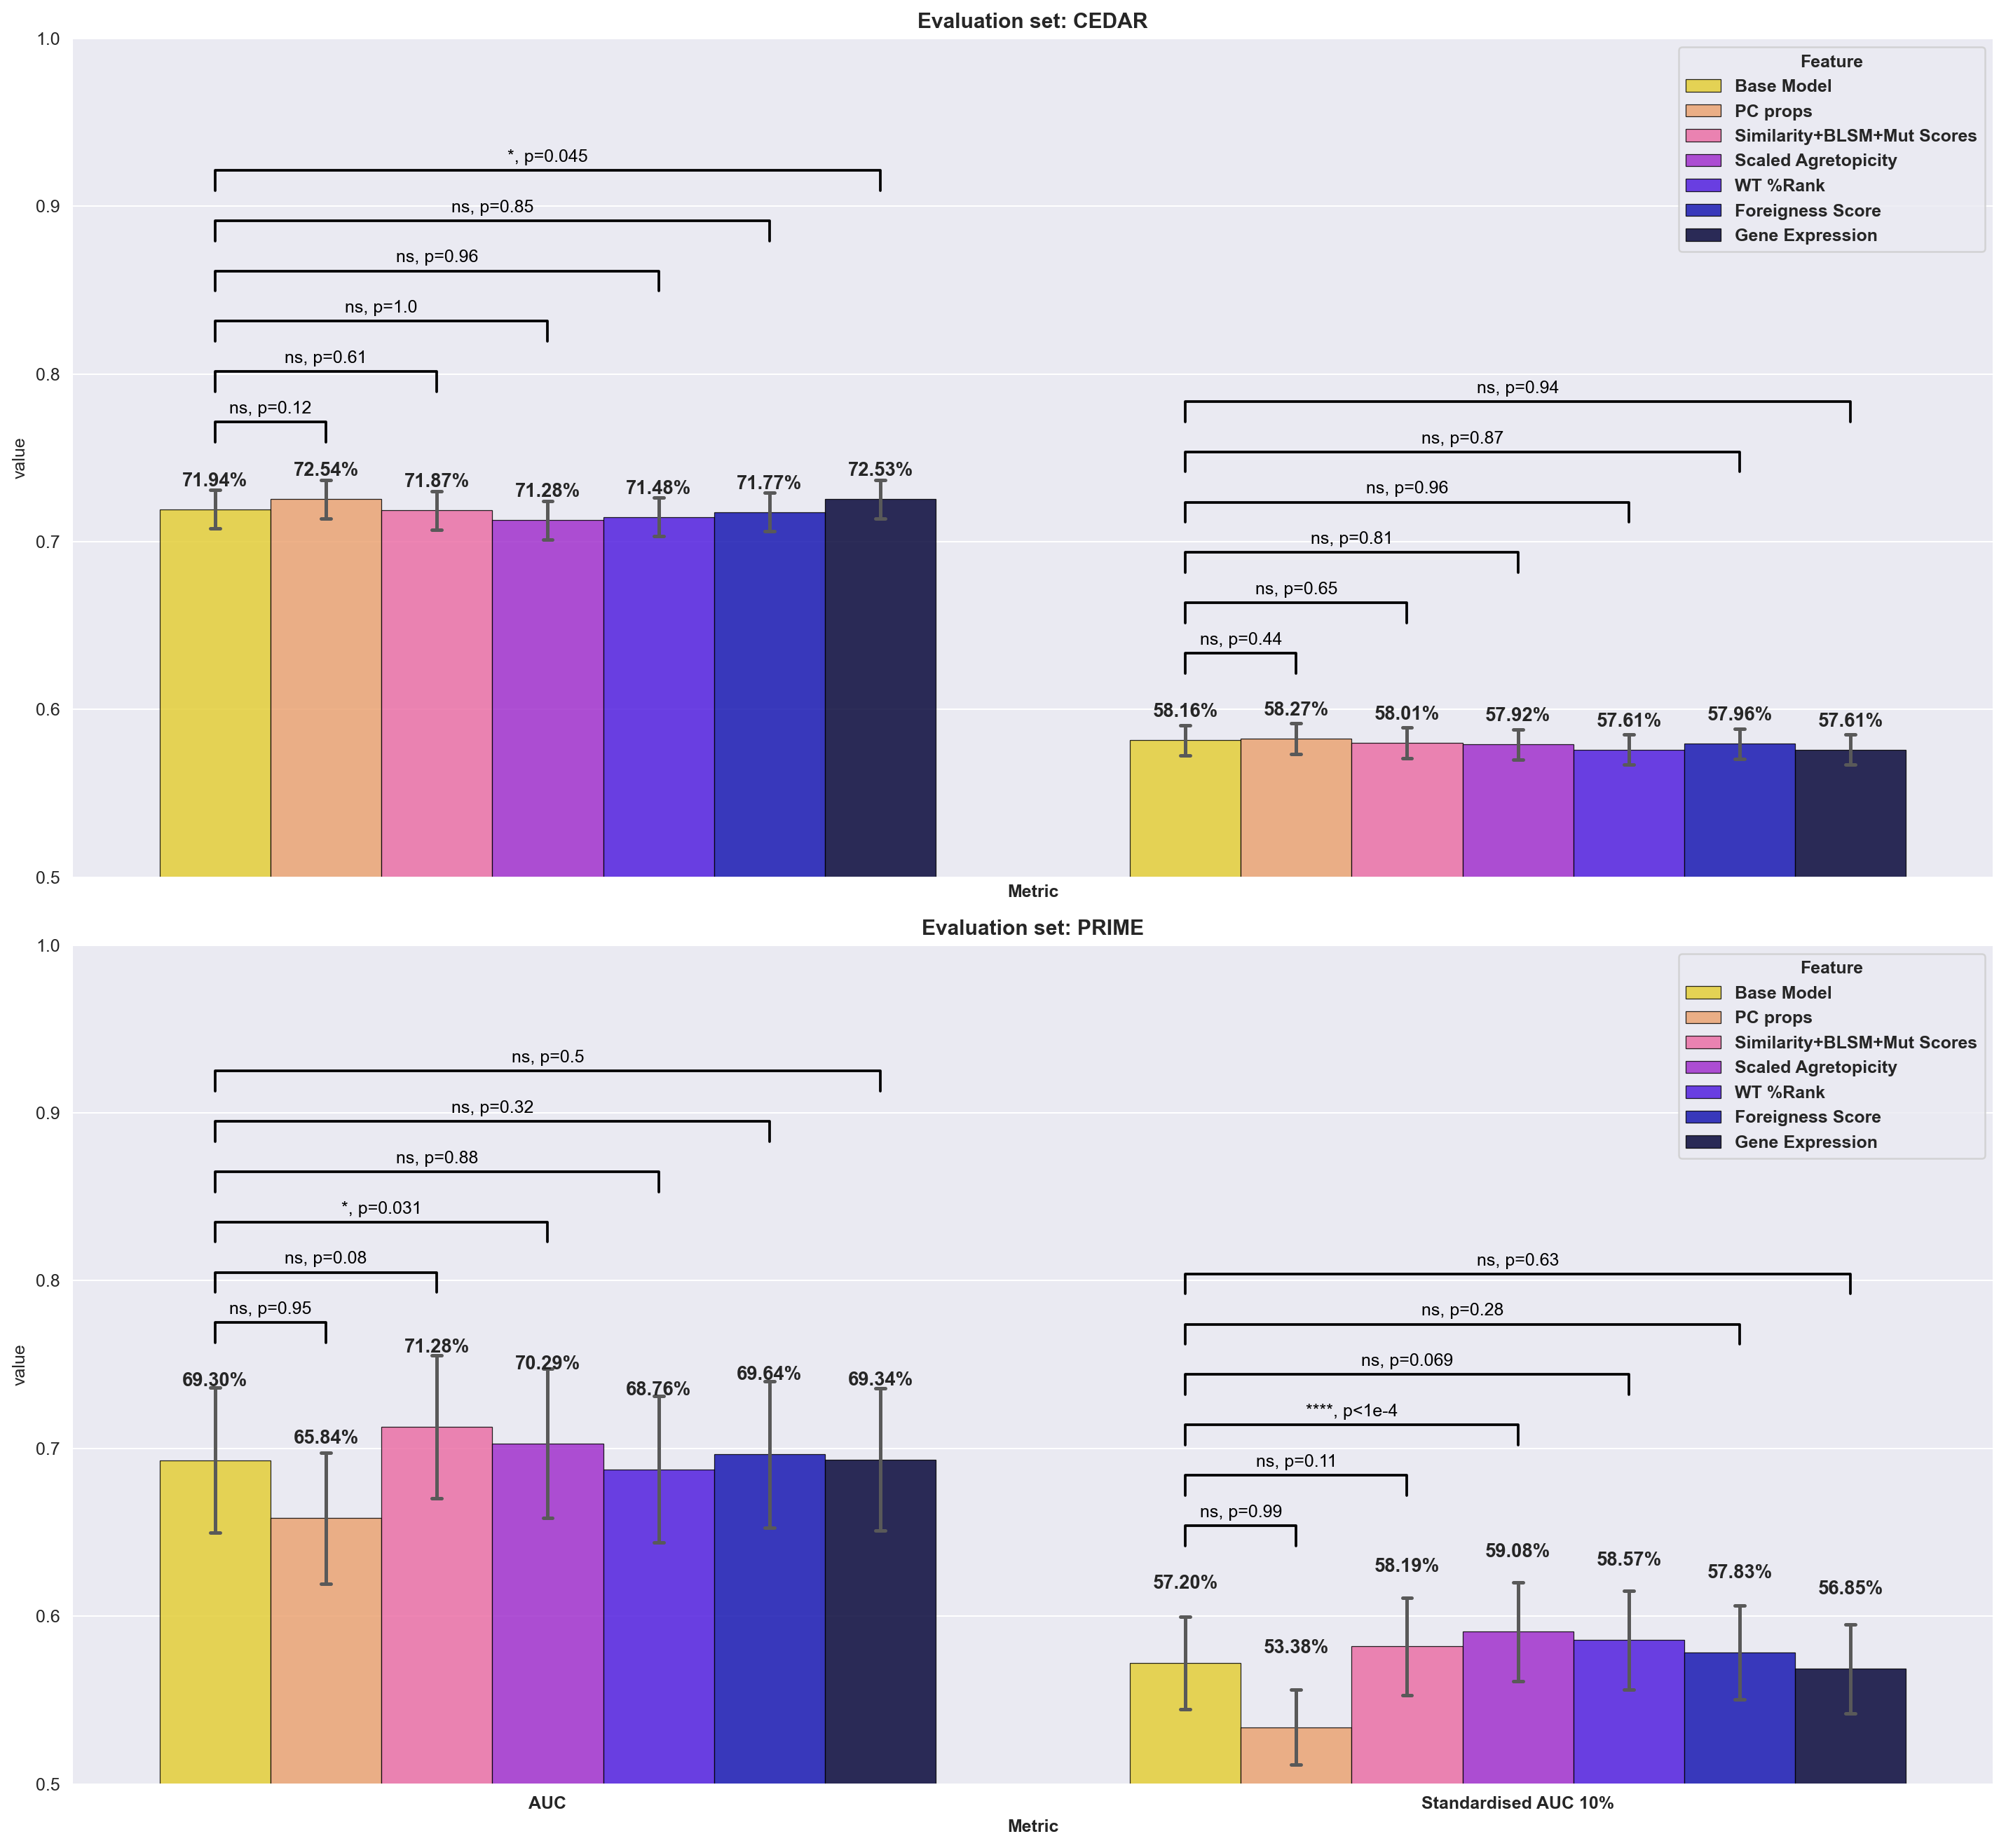

In [139]:
f,a = plt.subplots(2,1,figsize=(16,14.75), sharey=True, sharex=True)
pal = get_palette('gnuplot2_r', 7)
cmap = {k:v for k,v in zip(feature_map.values(), pal)}
for evalset, ax in zip(barplot_df.evalset.unique(), a.ravel()):
    tmp = barplot_df.query('evalset==@evalset').melt(id_vars=['evalset', 'Feature'],
                                                     value_vars = ['auc','auc_01']).assign(metric=lambda x: x['variable'].str.replace('_',' ').str.upper().replace('01', '10% FPR'))
    sns.barplot(data=tmp, x='metric', y='value', hue='Feature', width=.8, hue_order = list(feature_map.values()),
                ax=ax, palette=cmap, errorbar='sd', errcolor='.35', errwidth=2, capsize=.01)
    for container in ax.containers:
        values = [f'{x:.2%}' for x in container.datavalues]
        pad = 6*1.8 if evalset=='CEDAR' else 20*2
        ax.bar_label(container, labels=values, fontsize=11, fontweight='semibold', padding=pad)
    plt.setp(ax.patches, linewidth=0.5, edgecolor='k', alpha=0.85)
    ax.set_ylim([.5,1])
    # Pvalues, only for AUC 
    dx = ax.patches[0].get_width() 
    x0 = 0
    xs = [x0-3*dx, x0-2*dx, x0-1*dx, x0,
          x0+1*dx, x0+2*dx, x0+3*dx]
    x1 = xs[list(feature_map.values()).index('Base Model')]
    h = 0.04 if evalset=='CEDAR' else .07
    h0 = 0.015 if evalset=='CEDAR' else 0.015
    aucs_base = tmp.query('Feature=="Base Model" and evalset==@evalset and metric=="AUC"').value.values
    for i, comp in enumerate(list(feature_map.values())[1:]):
        x2 = xs[list(feature_map.values()).index(comp)]
        aucs_comp = tmp.query('evalset==@evalset and metric=="AUC" and Feature==@comp').value.values
        # if np.mean(aucs_base)>np.mean(aucs_comp):
        #     pval, sig = get_pval(aucs_base, aucs_comp)
        # else:
        
        # Always do pval(comparison > base )
        pval, sig = get_pval(aucs_comp, aucs_base)
            
        plot_pval(ax, pval, sig ,x1, x2, y=np.mean(aucs_base)+h,h=h0, color='k')
        h+=2*h0
        
    # Pvalues, only for AUC 01 
    dx = ax.patches[0].get_width() 
    x0 = 1
    xs = [x0-3*dx, x0-2*dx, x0-1*dx, x0,
          x0+1*dx, x0+2*dx, x0+3*dx]
    x1 = xs[list(feature_map.values()).index('Base Model')]
    h = 0.04 if evalset=='CEDAR' else .07
    h0 = 0.015 if evalset=='CEDAR' else 0.015
    aucs_base = tmp.query('Feature=="Base Model" and evalset==@evalset and metric=="AUC 01"').value.values
    for i, comp in enumerate(list(feature_map.values())[1:]):
        x2 = xs[list(feature_map.values()).index(comp)]
        aucs_comp = tmp.query('evalset==@evalset and metric=="AUC 01" and Feature==@comp').value.values
        # if np.mean(aucs_base)>np.mean(aucs_comp):
        #     pval, sig = get_pval(aucs_base, aucs_comp)
        # else:
        
        # Always do pval(comparison > base )
        pval, sig = get_pval(aucs_comp, aucs_base)
            
        plot_pval(ax, pval, sig ,x1, x2, y=np.mean(aucs_base)+h,h=h0, color='k')
        h+=2*h0
    ax.set_xticklabels(['AUC', 'Standardised AUC 10%'], fontweight='semibold')
    ax.set_xlabel('Metric', fontweight='semibold')
    ax.legend(loc='upper right', prop={'weight':'semibold'}, title='Feature', title_fontproperties={'weight':'semibold'})
    ax.set_title(f'Evaluation set: {evalset}', fontweight='semibold')
    
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/230428_FINAL_REDO_withExpr_features_comparison_barplot_pvals.png', 
          bbox_inches='tight', dpi=250)

# Optimal models

In [268]:
a = pd.read_csv('../output/230427_FINAL_ANALYSIS_ALL/gb_merged_exp8mers_pvals_expanded_input.csv').set_index(['input_type','weight','key'])
b = pd.read_csv('../output/230427_FINAL_ANALYSIS_ALL/gb_merged_exp8mers_pvals_icore_mut.csv').set_index(['input_type','weight','key'])
gb_merged = pd.concat([a,b]).reset_index().query('not (weight.str.contains("Inv") and weight.str.contains("Mask"))').set_index(['input_type','weight','key'])


In [364]:
display(gb_merged.reset_index().query('input_type=="icore_mut" and weight=="Shannon"').sort_values('mean_auc_CEDAR', ascending=False).head(1).set_index(['input_type', 'weight','key']))
display(gb_merged.reset_index().query('input_type!="icore_mut" and weight=="Shannon"').sort_values('mean_auc_CEDAR', ascending=False).head(1).set_index(['input_type', 'weight','key']))

mean_auc_CEDAR  \
input_type weight  key                                                   
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM        0.734703   

                                                        mean_auc01_CEDAR  \
input_type weight  key                                                     
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM          0.578184   

                                                        mean_auc_NEPDB  \
input_type weight  key                                                   
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM        0.745486   

                                                        mean_auc01_NEPDB  \
input_type weight  key                                                     
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM           0.60359   

                                                        mean_auc_PRIME  \
input_type weight  key                                                   
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM        0.673261   

                                                        mean_auc01_PRIME  \
input_type weight  key                                                     
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM          0.533537   

                                                        mean_auc_agg  \
input_type weight  key                                                 
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM      0.703982   

                                                        mean_auc_std  \
input_type weight  key                                                 
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM      0.030721   

                                                        Compromise  \
input_type weight  key                                               
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM    0.785667   

                                                        Unnamed: 0  \
input_type weight  key                                               
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM         0.0   

                                                        pval_icore_CEDAR  \
input_type weight  key                                                     
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM            0.0096   

                                                        pval_pep_CEDAR  \
input_type weight  key                                                   
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM             0.0   

                                                        pval_icore_PRIME  \
input_type weight  key                                                     
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM            0.7725   

                                                        pval_pep_PRIME  \
input_type weight  key                                                   
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM          0.5649   

                                                        mean_auc   std_auc  \
input_type weight  key                                                       
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM  0.703982  0.030721   

                                                        General  General2  \
input_type weight  key                                                      
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM  0.33663  0.469321   

                                                        General3  
input_type weight  key                                            
icore_mut  Shannon boman-blsm_mut_score-Total_Gene_TPM  0.459081

mean_auc_CEDAR  \
input_type     weight  key                                                   
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM        0.734665   

                                                            mean_auc01_CEDAR  \
input_type     weight  key                                                     
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM          0.577439   

                                                            mean_auc_NEPDB  \
input_type     weight  key                                                   
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM        0.750164   

                                                            mean_auc01_NEPDB  \
input_type     weight  key                                                     
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM          0.616622   

                                                            mean_auc_PRIME  \
input_type     weight  key                                                   
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM        0.671322   

                                                            mean_auc01_PRIME  \
input_type     weight  key                                                     
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM          0.542708   

                                                            mean_auc_agg  \
input_type     weight  key                                                 
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM      0.702993   

                                                            mean_auc_std  \
input_type     weight  key                                                 
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM      0.031671   

                                                            Compromise  \
input_type     weight  key                                               
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM    0.785163   

                                                            Unnamed: 0  \
input_type     weight  key                                               
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM         NaN   

                                                            pval_icore_CEDAR  \
input_type     weight  key                                                     
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM            0.0105   

                                                            pval_pep_CEDAR  \
input_type     weight  key                                                   
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM             0.0   

                                                            pval_icore_PRIME  \
input_type     weight  key                                                     
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM            0.7953   

                                                            pval_pep_PRIME  \
input_type     weight  key                                                   
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM           0.588   

                                                            mean_auc  \
input_type     weight  key                                             
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM  0.702993   

                                                             std_auc  \
input_type     weight  key                                             
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM  0.031671   

                                                             General  \
input_type     weight  key                                             
expanded_input Shannon boman-blsm_mut_score-Total_Gene_TPM  0.335661   

                                                            General2  General3  
input_type     weight  key                  

In [363]:
display(gb_merged.reset_index().query('input_type=="icore_mut" and weight=="KL"').sort_values('mean_auc_CEDAR', ascending=False).head(1).set_index(['input_type', 'weight','key']))
display(gb_merged.reset_index().query('input_type!="icore_mut"').sort_values('mean_auc_CEDAR', ascending=False).head(1).set_index(['input_type', 'weight','key']))

mean_auc_CEDAR  \
input_type weight key                                                                  
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.741664   

                                                                      mean_auc01_CEDAR  \
input_type weight key                                                                    
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.586496   

                                                                      mean_auc_NEPDB  \
input_type weight key                                                                  
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.749525   

                                                                      mean_auc01_NEPDB  \
input_type weight key                                                                    
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.608633   

                                                                      mean_auc_PRIME  \
input_type weight key                                                                  
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.669444   

                                                                      mean_auc01_PRIME  \
input_type weight key                                                                    
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.543405   

                                                                      mean_auc_agg  \
input_type weight key                                                                
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...      0.705554   

                                                                      mean_auc_std  \
input_type weight key                                                                
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...       0.03611   

                                                                      Compromise  \
input_type weight key                                                              
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...    0.788193   

                                                                      Unnamed: 0  \
input_type weight key                                                              
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...         0.0   

                                                                      pval_icore_CEDAR  \
input_type weight key                                                                    
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...            0.0865   

                                                                      pval_pep_CEDAR  \
input_type weight key                                                                  
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.0007   

                                                                      pval_icore_PRIME  \
input_type weight key                                                                    
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...            0.8165   

                                                                      pval_pep_PRIME  \
input_type weight key                                                                  
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.6135   

                                                                      mean_auc  \
input_type weight key                                                            
icore_mut  KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...  0.705554   

                                                                      std_auc  \
input_type weight key                 

mean_auc_CEDAR  \
input_type     weight key                                                                  
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.743343   

                                                                          mean_auc01_CEDAR  \
input_type     weight key                                                                    
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.585776   

                                                                          mean_auc_NEPDB  \
input_type     weight key                                                                  
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.737974   

                                                                          mean_auc01_NEPDB  \
input_type     weight key                                                                    
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.563207   

                                                                          mean_auc_PRIME  \
input_type     weight key                                                                  
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.6517   

                                                                          mean_auc01_PRIME  \
input_type     weight key                                                                    
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...           0.53185   

                                                                          mean_auc_agg  \
input_type     weight key                                                                
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...      0.697521   

                                                                          mean_auc_std  \
input_type     weight key                                                                
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...      0.045821   

                                                                          Compromise  \
input_type     weight key                                                              
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...    0.784596   

                                                                          Unnamed: 0  \
input_type     weight key                                                              
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...         0.0   

                                                                          pval_icore_CEDAR  \
input_type     weight key                                                                    
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...            0.0018   

                                                                          pval_pep_CEDAR  \
input_type     weight key                                                                  
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...             0.0   

                                                                          pval_icore_PRIME  \
input_type     weight key                                                                    
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...            0.9213   

                                                                          pval_pep_PRIME  \
input_type     weight key                                                                  
expanded_input KL     boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.7819   

                                                                          mean_auc  \
input_type     weight key                                                            
expanded_input KL     boman-bl

In [269]:
for c, evalset in zip(['mean_auc_CEDAR', 'mean_auc_PRIME', 'Compromise'],
                      ['CEDAR', 'PRIME', 'CEDAR']):
    print('#'*100, '\n\n\n', 'ALL SIGS', c, '\n\n\n', '#'*100)
    display(gb_merged.sort_values(c, ascending=False).head(3))
    
    
    print('#'*100, '\n\n\n', 'ALL SIGS', c, '\n\n\n', '#'*100)
    prompt = f'pval_icore_{evalset}<0.05 or pval_pep_{evalset}<0.05'
    display(gb_merged.query(prompt).sort_values(c, ascending=False).head(3))

#################################################################################################### 


 ALL SIGS mean_auc_CEDAR 


 ####################################################################################################


mean_auc_CEDAR  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.743343   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.743026   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.742967   

                                                                               mean_auc01_CEDAR  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.585776   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                      0.588283   
                           boman-blsm_mut_score-Total_Gene_TPM                         0.587958   

                                                                               mean_auc_NEPDB  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.737974   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.734888   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.729666   

                                                                               mean_auc01_NEPDB  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.563207   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                      0.545990   
                           boman-blsm_mut_score-Total_Gene_TPM                         0.547020   

                                                                               mean_auc_PRIME  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.651700   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.642711   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.649454   

                                                                               mean_auc01_PRIME  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.531850   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                      0.520890   
                           boman-blsm_mut_score-Total_Gene_TPM                         0.520287   

                                                                               mean_auc_agg  \
input_type     weight      key                                                                
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...      0.697521   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                  0.692868   
                           boman-blsm_mut_score-Total_Gene_TPM                     0.696210   

                                                                               mean_auc_std  \
input_type     weight      key                                                                
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...      0.045821   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                  0.050158   
                           boman-blsm_mut_score-Total_Gene_TPM                     0.046757   

                                                                               Compromise  \
input_type     weight      key                                                          

#################################################################################################### 


 ALL SIGS mean_auc_CEDAR 


 ####################################################################################################


mean_auc_CEDAR  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.743343   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.743026   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.742967   

                                                                               mean_auc01_CEDAR  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.585776   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                      0.588283   
                           boman-blsm_mut_score-Total_Gene_TPM                         0.587958   

                                                                               mean_auc_NEPDB  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.737974   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.734888   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.729666   

                                                                               mean_auc01_NEPDB  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.563207   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                      0.545990   
                           boman-blsm_mut_score-Total_Gene_TPM                         0.547020   

                                                                               mean_auc_PRIME  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.651700   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.642711   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.649454   

                                                                               mean_auc01_PRIME  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...          0.531850   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                      0.520890   
                           boman-blsm_mut_score-Total_Gene_TPM                         0.520287   

                                                                               mean_auc_agg  \
input_type     weight      key                                                                
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...      0.697521   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                  0.692868   
                           boman-blsm_mut_score-Total_Gene_TPM                     0.696210   

                                                                               mean_auc_std  \
input_type     weight      key                                                                
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...      0.045821   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                  0.050158   
                           boman-blsm_mut_score-Total_Gene_TPM                     0.046757   

                                                                               Compromise  \
input_type     weight      key                                                          

#################################################################################################### 


 ALL SIGS mean_auc_PRIME 


 ####################################################################################################


mean_auc_CEDAR  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.710399   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.712337   
                   dissimilarity_score-blsm_mut_score                        0.708982   

                                                                       mean_auc01_CEDAR  \
input_type weight  key                                                                    
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...          0.567883   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...          0.569128   
                   dissimilarity_score-blsm_mut_score                          0.568695   

                                                                       mean_auc_NEPDB  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.801430   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.804569   
                   dissimilarity_score-blsm_mut_score                        0.750366   

                                                                       mean_auc01_NEPDB  \
input_type weight  key                                                                    
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...          0.649083   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...          0.657419   
                   dissimilarity_score-blsm_mut_score                          0.614693   

                                                                       mean_auc_PRIME  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.721912   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.721371   
                   dissimilarity_score-blsm_mut_score                        0.721218   

                                                                       mean_auc01_PRIME  \
input_type weight  key                                                                    
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...          0.615661   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...          0.615861   
                   dissimilarity_score-blsm_mut_score                          0.601745   

                                                                       mean_auc_agg  \
input_type weight  key                                                                
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...      0.716155   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...      0.716854   
                   dissimilarity_score-blsm_mut_score                      0.715100   

                                                                       mean_auc_std  \
input_type weight  key                                                                
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...      0.005757   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...      0.004517   
                   dissimilarity_score-blsm_mut_score                      0.006118   

                                                                       Compromise  \
input_type weight  key                                                              
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...    0.782799   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...    0.784253   
                   dissimilarity_score-blsm_mut_score                    0.781736   

                                                                   

#################################################################################################### 


 ALL SIGS mean_auc_PRIME 


 ####################################################################################################


mean_auc_CEDAR  \
input_type     weight key                                                                  
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...        0.711585   
                      dissimilarity_score-blsm_mut_score-ratio_rank             0.714437   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank             0.714437   

                                                                          mean_auc01_CEDAR  \
input_type     weight key                                                                    
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...          0.579162   
                      dissimilarity_score-blsm_mut_score-ratio_rank               0.581810   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank               0.581810   

                                                                          mean_auc_NEPDB  \
input_type     weight key                                                                  
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...        0.739036   
                      dissimilarity_score-blsm_mut_score-ratio_rank             0.735607   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank             0.735607   

                                                                          mean_auc01_NEPDB  \
input_type     weight key                                                                    
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...          0.607494   
                      dissimilarity_score-blsm_mut_score-ratio_rank               0.607413   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank               0.607413   

                                                                          mean_auc_PRIME  \
input_type     weight key                                                                  
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...        0.717814   
                      dissimilarity_score-blsm_mut_score-ratio_rank             0.717507   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank             0.717507   

                                                                          mean_auc01_PRIME  \
input_type     weight key                                                                    
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...          0.604579   
                      dissimilarity_score-blsm_mut_score-ratio_rank               0.605622   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank               0.605622   

                                                                          mean_auc_agg  \
input_type     weight key                                                                
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...      0.714699   
                      dissimilarity_score-blsm_mut_score-ratio_rank           0.715972   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank           0.715972   

                                                                          mean_auc_std  \
input_type     weight key                                                                
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...      0.003114   
                      dissimilarity_score-blsm_mut_score-ratio_rank           0.001535   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank           0.001535   

                                                                          Compromise  \
input_type     weight key                                                              
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...    0.783689   
                      dissimilarity_score-blsm_mut_score-ratio_rank         0.785828   
icore_mut      None   di

#################################################################################################### 


 ALL SIGS Compromise 


 ####################################################################################################


mean_auc_CEDAR  \
input_type     weight key                                                                 
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.727866   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.727866   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM          0.730140   

                                                                         mean_auc01_CEDAR  \
input_type     weight key                                                                   
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.576827   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.576827   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM            0.578365   

                                                                         mean_auc_NEPDB  \
input_type     weight key                                                                 
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.773353   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.773353   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM          0.755900   

                                                                         mean_auc01_NEPDB  \
input_type     weight key                                                                   
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.627582   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.627582   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM            0.593667   

                                                                         mean_auc_PRIME  \
input_type     weight key                                                                 
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.709702   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.709702   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM          0.703050   

                                                                         mean_auc01_PRIME  \
input_type     weight key                                                                   
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.576791   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.576791   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM            0.570121   

                                                                         mean_auc_agg  \
input_type     weight key                                                               
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM      0.718784   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM      0.718784   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM        0.716595   

                                                                         mean_auc_std  \
input_type     weight key                                                               
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM      0.009082   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM      0.009082   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM        0.013545   

                                                                         Compromise  \
input_type     weight key                                                             
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM    0.791359   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM    0.791359   
                      blsm_mut_score-foreignness_score-Total_Gene_T

#################################################################################################### 


 ALL SIGS Compromise 


 ####################################################################################################


mean_auc_CEDAR  \
input_type     weight key                                                                 
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.727866   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.727866   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM          0.730140   

                                                                         mean_auc01_CEDAR  \
input_type     weight key                                                                   
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.576827   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.576827   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM            0.578365   

                                                                         mean_auc_NEPDB  \
input_type     weight key                                                                 
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.773353   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.773353   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM          0.755900   

                                                                         mean_auc01_NEPDB  \
input_type     weight key                                                                   
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.627582   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.627582   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM            0.593667   

                                                                         mean_auc_PRIME  \
input_type     weight key                                                                 
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.709702   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM        0.709702   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM          0.703050   

                                                                         mean_auc01_PRIME  \
input_type     weight key                                                                   
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.576791   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM          0.576791   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM            0.570121   

                                                                         mean_auc_agg  \
input_type     weight key                                                               
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM      0.718784   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM      0.718784   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM        0.716595   

                                                                         mean_auc_std  \
input_type     weight key                                                               
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM      0.009082   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM      0.009082   
                      blsm_mut_score-foreignness_score-Total_Gene_TPM        0.013545   

                                                                         Compromise  \
input_type     weight key                                                             
expanded_input None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM    0.791359   
icore_mut      None   dissimilarity_score-blsm_mut_score-Total_Gene_TPM    0.791359   
                      blsm_mut_score-foreignness_score-Total_Gene_T

In [286]:
cols = ['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_icore_CEDAR', 'pval_pep_CEDAR', 'pval_icore_PRIME', 'pval_pep_PRIME']

In [287]:
gb_merged['mean_auc'] = 0.5* (gb_merged['mean_auc_CEDAR'] + gb_merged['mean_auc_PRIME'])
gb_merged['std_auc'] = gb_merged.apply(lambda x: np.std([x['mean_auc_CEDAR'], x['mean_auc_PRIME']]), axis=1)
gb_merged['General'] = gb_merged.apply(lambda x: 0.5*x['mean_auc'] - 0.5 * x['std_auc'], axis=1)
gb_merged['General2'] = gb_merged.apply(lambda x: 1/3*x['mean_auc_CEDAR'] + 1/3 * x['mean_auc'] - 1/3 * x['std_auc'], axis=1)
gb_merged['General3'] = gb_merged.apply(lambda x: 1/3*x['mean_auc_CEDAR'] + 1/3 * x['mean_auc_PRIME'] - 1/3 * x['std_auc'], axis=1)
gb_merged.sort_values('General', ascending=False).head(10)[cols]

mean_auc_CEDAR  \
input_type weight  key                                                                  
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_...        0.719732   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.719588   
                   blsm_mut_score-Total_Gene_TPM                             0.719122   
           Mask    blsm_mut_score-Total_Gene_TPM                             0.718618   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718290   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718216   
           Mask    dissimilarity_score-blsm_mut_score-foreignness_...        0.717945   
                   blsm_mut_score-foreignness_score-Total_Gene_TPM           0.719749   
           KL-Mask blsm_mut_score-foreignness_score-Total_Gene_TPM           0.719960   
                   dissimilarity_score-blsm_mut_score-foreignness_...        0.717254   

                                                                       mean_auc_PRIME  \
input_type weight  key                                                                  
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_...        0.719726   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.719117   
                   blsm_mut_score-Total_Gene_TPM                             0.719039   
           Mask    blsm_mut_score-Total_Gene_TPM                             0.718979   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.720833   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.720788   
           Mask    dissimilarity_score-blsm_mut_score-foreignness_...        0.719285   
                   blsm_mut_score-foreignness_score-Total_Gene_TPM           0.717832   
           KL-Mask blsm_mut_score-foreignness_score-Total_Gene_TPM           0.717741   
                   dissimilarity_score-blsm_mut_score-foreignness_...        0.716879   

                                                                       mean_auc_NEPDB  \
input_type weight  key                                                                  
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_...        0.767096   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.770530   
                   blsm_mut_score-Total_Gene_TPM                             0.780927   
           Mask    blsm_mut_score-Total_Gene_TPM                             0.779980   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.796507   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.803688   
           Mask    dissimilarity_score-blsm_mut_score-foreignness_...        0.792048   
                   blsm_mut_score-foreignness_score-Total_Gene_TPM           0.767909   
           KL-Mask blsm_mut_score-foreignness_score-Total_Gene_TPM           0.775030   
                   dissimilarity_score-blsm_mut_score-foreignness_...        0.796198   

                                                                       pval_icore_CEDAR  \
input_type weight  key                                                                    
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_...            0.4865   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...            0.4930   
                   blsm_mut_score-Total_Gene_TPM                                 0.5208   
           Mask    blsm_mut_score-Total_Gene_TPM                                 0.5555   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.5756   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.5798   
           Mask    dissimilarity_score-blsm_mut_score-foreignness_...            0.5920   
                   blsm_mut_score-foreignness

In [328]:
import itertools
queries = ['pval_pep_CEDAR<0.05', 'pval_icore_CEDAR<0.05', 'pval_pep_PRIME<0.05', 'pval_icore_PRIME<0.05']
queries = list(itertools.combinations_with_replacement(queries, 2))
queries = [x for x in [' and '.join(x) for x in queries] if 'PRIME' in x and 'CEDAR' in x]
queries = ' or '.join([f'({x})' for x in queries])
queries = queries + ' and input_type=="expanded_input"'

In [338]:
xxx= gb_merged.reset_index().set_index(['input_type', 'weight','key'])

In [339]:
xxx.sort_values('General', ascending=False).head()

mean_auc_CEDAR  \
input_type weight  key                                                                  
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_...        0.719732   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.719588   
                   blsm_mut_score-Total_Gene_TPM                             0.719122   
           Mask    blsm_mut_score-Total_Gene_TPM                             0.718618   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718290   

                                                                       mean_auc01_CEDAR  \
input_type weight  key                                                                    
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_...          0.569815   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...          0.571275   
                   blsm_mut_score-Total_Gene_TPM                               0.568360   
           Mask    blsm_mut_score-Total_Gene_TPM                               0.566446   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.568318   

                                                                       mean_auc_NEPDB  \
input_type weight  key                                                                  
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_...        0.767096   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.770530   
                   blsm_mut_score-Total_Gene_TPM                             0.780927   
           Mask    blsm_mut_score-Total_Gene_TPM                             0.779980   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.796507   

                                                                       mean_auc01_NEPDB  \
input_type weight  key                                                                    
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_...          0.621147   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...          0.614586   
                   blsm_mut_score-Total_Gene_TPM                               0.609688   
           Mask    blsm_mut_score-Total_Gene_TPM                               0.613334   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.647015   

                                                                       mean_auc_PRIME  \
input_type weight  key                                                                  
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_...        0.719726   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.719117   
                   blsm_mut_score-Total_Gene_TPM                             0.719039   
           Mask    blsm_mut_score-Total_Gene_TPM                             0.718979   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.720833   

                                                                       mean_auc01_PRIME  \
input_type weight  key                                                                    
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_...          0.593471   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...          0.591757   
                   blsm_mut_score-Total_Gene_TPM                               0.589373   
           Mask    blsm_mut_score-Total_Gene_TPM                               0.586360   
                   dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.598510   

                                                                       mean_auc_agg  \
input_type weight  key                                                                
icore_mut  Mask    isoelectric_point-dissimilarity_score-blsm_mut_...      0.719729   
           KL-Mask isoel

In [359]:
xxx.reset_index(['input_type']).sort_values('mean_auc_PRIME',ascending=False).groupby(['input_type']).agg(best=('mean_auc_PRIME','first'))

best
input_type              
expanded_input  0.717814
icore_mut       0.721912

In [348]:
xxx.sort_values('mean_auc_PRIME',ascending=False).head(25)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB']]

mean_auc_CEDAR  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.710399   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.712337   
                   dissimilarity_score-blsm_mut_score                        0.708982   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...        0.713958   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank             0.703655   
           Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718290   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718216   
           Mask    dissimilarity_score-blsm_mut_score                        0.708506   
                   dissimilarity_score-blsm_mut_score-ratio_rank             0.703913   
           KL-Mask blsm_mut_score-ratio_rank-Total_Gene_TPM                  0.713239   
           Mask    isoelectric_point-dissimilarity_score-blsm_mut_...        0.719732   
                   isoelectric_point-dissimilarity_score-blsm_mut_...        0.713042   
                   dissimilarity_score-ratio_rank-Total_Gene_TPM             0.710160   
           KL-Mask blsm_mut_score-ratio_rank-foreignness_score-Tot...        0.713811   
           Mask    blsm_mut_score-ratio_rank-Total_Gene_TPM                  0.712840   
                   dissimilarity_score-blsm_mut_score-foreignness_...        0.717945   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.719588   
                   blsm_mut_score-Total_Gene_TPM                             0.719122   
                   isoelectric_point-dissimilarity_score-blsm_mut_...        0.713539   
           Mask    dissimilarity_score-blsm_mut_score-ratio_rank-f...        0.712620   
                   blsm_mut_score-Total_Gene_TPM                             0.718618   
           KL-Mask dissimilarity_score-ratio_rank-Total_Gene_TPM             0.710797   
           Mask    dissimilarity_score-ratio_rank-foreignness_scor...        0.710384   
                   dissimilarity_score-Total_Gene_TPM                        0.716500   
                   isoelectric_point-dissimilarity_score-ratio_ran...        0.711508   

                                                                       mean_auc_PRIME  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.721912   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.721371   
                   dissimilarity_score-blsm_mut_score                        0.721218   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...        0.721145   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank             0.721017   
           Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.720833   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.720788   
           Mask    dissimilarity_score-blsm_mut_score                        0.720520   
                   dissimilarity_score-blsm_mut_score-ratio_rank             0.719952   
           KL-Mask blsm_mut_score-ratio_rank-Total_Gene_TPM                  0.719904   
           Mask    isoelectric_point-dissimilarity_score-blsm_mut_...        0.719726   
                   isoelectric_point-dissimilarity_score-blsm_mut_...        0.719667   
                   dissimilarity_score-ratio_rank-Total_Gene_TPM             0.719582   
           KL-Mask blsm_mut_score-ratio_rank-foreignness_score-Tot...        0.719571   
           Mask    blsm_mut_score-ratio_rank-Total_Gene_TPM                  0.719565   
                   dissimilarity_score-blsm_mut_score-foreignness_...        0.719285   
           KL-Mask isoelectric_point-dissimilarity_score-blsm_mut

In [343]:
xxx.sort_values('General', ascending=False).head(25)[cols]

mean_auc_CEDAR  \
input_type     weight  key                                                                  
icore_mut      Mask    isoelectric_point-dissimilarity_score-blsm_mut_...        0.719732   
               KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.719588   
                       blsm_mut_score-Total_Gene_TPM                             0.719122   
               Mask    blsm_mut_score-Total_Gene_TPM                             0.718618   
                       dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718290   
               KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718216   
               Mask    dissimilarity_score-blsm_mut_score-foreignness_...        0.717945   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.719749   
               KL-Mask blsm_mut_score-foreignness_score-Total_Gene_TPM           0.719960   
                       dissimilarity_score-blsm_mut_score-foreignness_...        0.717254   
                       dissimilarity_score-Total_Gene_TPM                        0.716951   
expanded_input KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718612   
icore_mut      Mask    dissimilarity_score-Total_Gene_TPM                        0.716500   
               KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.720633   
expanded_input Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718293   
               KL-Mask blsm_mut_score-foreignness_score-Total_Gene_TPM           0.720192   
icore_mut      KL-Mask isoelectric_point-blsm_mut_score-ratio_rank-for...        0.715957   
expanded_input KL-Mask blsm_mut_score-Total_Gene_TPM                             0.718862   
icore_mut      Mask    isoelectric_point-dissimilarity_score-blsm_mut_...        0.720212   
expanded_input Mask    blsm_mut_score-Total_Gene_TPM                             0.718104   
icore_mut      Mask    isoelectric_point-blsm_mut_score-ratio_rank-for...        0.715540   
                       isoelectric_point-blsm_mut_score-foreignness_sc...        0.721614   
expanded_input Mask    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.720214   
icore_mut      KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.715342   
                       isoelectric_point-dissimilarity_score-Total_Gen...        0.719357   

                                                                           mean_auc_PRIME  \
input_type     weight  key                                                                  
icore_mut      Mask    isoelectric_point-dissimilarity_score-blsm_mut_...        0.719726   
               KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.719117   
                       blsm_mut_score-Total_Gene_TPM                             0.719039   
               Mask    blsm_mut_score-Total_Gene_TPM                             0.718979   
                       dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.720833   
               KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.720788   
               Mask    dissimilarity_score-blsm_mut_score-foreignness_...        0.719285   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.717832   
               KL-Mask blsm_mut_score-foreignness_score-Total_Gene_TPM           0.717741   
                       dissimilarity_score-blsm_mut_score-foreignness_...        0.716879   
                       dissimilarity_score-Total_Gene_TPM                        0.716769   
expanded_input KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.716653   
icore_mut      Mask    dissimilarity_score-Total_Gene_TPM                        0.718247   
               KL-Mask isoelectric_point-dissimilarity_score-blsm_mut_...        0.716368   
expanded_input Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM   

In [340]:
xxx.sort_values('Compromise', ascending=False).head()[cols]

mean_auc_CEDAR  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.728986   

                                                                           mean_auc_PRIME  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.709702   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.709702   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.703050   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.703050   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.704594   

                                                                           mean_auc_NEPDB  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.790994   

                                                                           pval_icore_CEDAR  \
input_type     weight  key                                                                    
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.0204   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.0204   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM               0.0043   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM               0.0043   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...            0.0588   

                                                                           pval_pep_CEDAR  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.0001   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.0001   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM             0.0000   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM             0.0000   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...          0.0005   

                                                                           pval_icore_PRIME  \
input_type     weight  key                                                                    
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.1853   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.1853   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM               0.2654   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM               0.2654   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...            0.3123   

                                                                           pval_pep_PRIME  
input_type     weight  key                 

In [261]:
gb_merged.reset_index().query('not (weight.str.contains("Inv") and weight.str.contains("Mask"))')\
         .set_index(['input_type','weight','key']).sort_values('Compromise', ascending=False).head(10)

mean_auc_CEDAR  \
input_type     weight  key                                                                  
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
icore_mut      None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
icore_mut      None    dissimilarity_score-blsm_mut_score-foreignness_...        0.726110   
expanded_input None    dissimilarity_score-blsm_mut_score-foreignness_...        0.726110   
                       isoelectric_point-dissimilarity_score-blsm_mut_...        0.726283   
icore_mut      None    isoelectric_point-dissimilarity_score-blsm_mut_...        0.726283   
expanded_input KL-Mask aliphatic_index-blsm_mut_score-foreignness_scor...        0.731428   
                       aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.730727   

                                                                           mean_auc01_CEDAR  \
input_type     weight  key                                                                    
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.576827   
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.576827   
icore_mut      None    blsm_mut_score-foreignness_score-Total_Gene_TPM             0.578365   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM             0.578365   
icore_mut      None    dissimilarity_score-blsm_mut_score-foreignness_...          0.575064   
expanded_input None    dissimilarity_score-blsm_mut_score-foreignness_...          0.575064   
                       isoelectric_point-dissimilarity_score-blsm_mut_...          0.580145   
icore_mut      None    isoelectric_point-dissimilarity_score-blsm_mut_...          0.580145   
expanded_input KL-Mask aliphatic_index-blsm_mut_score-foreignness_scor...          0.585672   
                       aliphatic_index-dissimilarity_score-blsm_mut_sc...          0.585665   

                                                                           mean_auc_NEPDB  \
input_type     weight  key                                                                  
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
icore_mut      None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
icore_mut      None    dissimilarity_score-blsm_mut_score-foreignness_...        0.772853   
expanded_input None    dissimilarity_score-blsm_mut_score-foreignness_...        0.772853   
                       isoelectric_point-dissimilarity_score-blsm_mut_...        0.759025   
icore_mut      None    isoelectric_point-dissimilarity_score-blsm_mut_...        0.759025   
expanded_input KL-Mask aliphatic_index-blsm_mut_score-foreignness_scor...        0.773204   
                       aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.786560   

                                                                           mean_auc01_NEPDB  \
input_type     weight  key                                                                    
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.627582   
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.627582   
icore_mut      None    blsm_mut_score-foreignness_score-Total_Gene_TPM             0.593667   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM             0.593667   
icore_mut      None    dissimilarity_score-blsm_mut_score-foreignness_...          0.624165   
expanded_input None    dissimilarit

In [152]:
cedar_aligned_expr.drop(columns=[x for x in filter(lambda x: 'Unnamed' in x, cedar_aligned_expr.columns)]).query('foreignness_score>0.9')

Peptide        HLA  EL_rank_mut  agg_label  fold  EL_rank_wt  \
5     AALHTPRPGPL  HLA-B0702       2.5335          0     9      2.4193   
49    ALAQERWRCLV  HLA-A0201       2.3931          0     1      8.1905   
55     ALAVKALYPV  HLA-A0201       1.4656          0     0      0.1931   
68    ALFLVFGRTRK  HLA-A1101       1.4748          1     7      1.1815   
77      ALHSPRCYR  HLA-A0301       0.4339          0     5      3.0385   
...           ...        ...          ...        ...   ...         ...   
2887  YMHTDLQALHM  HLA-C1203       0.5756          0     9      0.2841   
2904    YPAPQPPVL  HLA-B0801       0.0836          0     6      0.1456   
2909    YPPPPPALL  HLA-B0702       0.0508          1     5      0.0810   
2960    YTWPSGNIY  HLA-A0101       0.0552          0     7      0.0374   
2984    YYPGKKEPF  HLA-A2402       0.0965          0     0      0.0817   

      EL_rank_wt_aligned  Total_Gene_TPM  Total_Peptide_TPM  \
5                 2.4193        0.383008              0.383   
49               28.8519        2.851060              2.851   
55                0.1931       10.021300             10.021   
68                1.1815        0.130996              0.131   
77                3.0385        2.681050              2.681   
...                  ...             ...                ...   
2887              0.2841        0.001000              0.001   
2904              0.1456        3.070980              3.071   
2909              1.2088       22.031600             22.032   
2960              0.0374        1.511990              1.512   
2984              0.0817    12671.500000          12671.500   

      Total_Scaled_Peptide_TPM  ...  len_icore_mut     seq_id  \
5                        0.383  ...             10     >seq_6   
49                       2.138  ...              9    >seq_50   
55                       3.337  ...             10    >seq_56   
68                       0.131  ...             11    >seq_69   
77                       0.893  ...              9    >seq_78   
...                        ...  ...            ...        ...   
2887                     0.001  ...              9  >seq_2933   
2904                     2.457  ...              9  >seq_2950   
2909                    22.032  ...              9  >seq_2955   
2960                     0.802  ...              9  >seq_3006   
2984                 12671.500  ...              9  >seq_3030   

      trueHLA_EL_rank    wild_type  foreignness_score  ratio_rank impr_icore  \
5              4.2778  AALHNPRPGPL           1.000000    0.119591      False   
49             2.5237  AFAQERWRCLV           1.000000    2.194606      False   
55             1.4656   ALAEKALYPV           0.999941    9.658084      False   
68             1.4748  ALFLVFGRTKK           1.000000    0.366110      False   
77             0.4339    AFHSPRCYR           0.996176    0.371939       True   
...               ...          ...                ...         ...        ...   
2887          11.9384  YMYTDLQALHM           0.996176    0.590593      False   
2904           0.0836    SPAPQPPVL           0.992380    0.035599      False   
2909           0.0508    YPPPPPALP           0.992380    0.048665       True   
2960           0.0552    YTWPSGNTY           0.996176    0.026272      False   
2984           0.0965    YYSGKKEPF           1.000000    0.017481      False   

     impr_pep  ic_len expanded_input  
5       False   47675     ALHTPRPGPL  
49      False   83295      ALAQERWRC  
55      False   15215     ALAVKALYPV  
68      False   19479    ALFLVFGRTRK  
77       True   61640      ALHSPRCYR  
...       ...     ...            ...  
2887    False   94776      YMHTDLQAL  
2904    False   88398      YPAPQPPVL  
2909    False   73978      YPPPPPALL  
2960    False   35888      YTWPSGNIY  
2984    False   52592      YYPGKKEPF  

[271 rows x 42 columns]

In [336]:
for c in ['mean_auc_CEDAR', 'mean_auc_PRIME', 'Compromise']:
    print('#'*30,'\n'*3, c, '\n', '#'*30,'\n'*3)
    print('\t\tALL WITH INVERTEDMASK')
    temp = gb_merged
    display(temp.sort_values(c,ascending=False).head(8)[['mean_auc_CEDAR', 'mean_auc_PRIME','mean_auc_NEPDB', 'pval_icore_CEDAR', 'pval_pep_CEDAR', 'pval_icore_PRIME', 'pval_pep_PRIME']])
    print('\t\t SIG only')
    f = 'PRIME' if 'PRIME' in c else 'CEDAR'
    display(temp.query(f'pval_icore_{f} < 0.05 or pval_pep_{f}<0.05').sort_values(c, ascending=False).head(8)[['mean_auc_CEDAR', 'mean_auc_PRIME','mean_auc_NEPDB', 'pval_icore_CEDAR', 'pval_pep_CEDAR', 'pval_icore_PRIME', 'pval_pep_PRIME']])

############################## 


 mean_auc_CEDAR 
 ############################## 



		ALL WITH INVERTEDMASK


mean_auc_CEDAR  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.743343   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.743026   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.742967   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.742760   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.742759   
               Inv-Shannon boman-Total_Gene_TPM                                      0.742725   
               KL          boman-blsm_mut_score-foreignness_score-Total_Ge...        0.742575   
icore_mut      Inv-Shannon boman-isoelectric_point-blsm_mut_score-Total_Ge...        0.742509   

                                                                               mean_auc_PRIME  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.651700   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.642711   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.649454   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.647620   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.649924   
               Inv-Shannon boman-Total_Gene_TPM                                      0.644823   
               KL          boman-blsm_mut_score-foreignness_score-Total_Ge...        0.650532   
icore_mut      Inv-Shannon boman-isoelectric_point-blsm_mut_score-Total_Ge...        0.649648   

                                                                               mean_auc_NEPDB  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.737974   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.734888   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.729666   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.747837   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.712897   
               Inv-Shannon boman-Total_Gene_TPM                                      0.741242   
               KL          boman-blsm_mut_score-foreignness_score-Total_Ge...        0.714896   
icore_mut      Inv-Shannon boman-isoelectric_point-blsm_mut_score-Total_Ge...        0.728199   

                                                                               pval_icore_CEDAR  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...            0.0018   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                        0.0019   
                           boman-blsm_mut_score-Total_Gene_TPM                           0.0018   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                       0.0017   
                           boman-blsm_mut_score-Total_Gene_TPM                           0.0023   
               Inv-Shannon boman-Total_Gene_TPM                                          0.0022   
               KL          boman-blsm_mut_score-foreignness_score-Total_Ge...            0.0023   
icore_mut      Inv-Shannon boman-isoelectric_point-blsm_mut_score-Total_Ge...            0.0020   

                                                                               pval_pep_CEDAR  \
input_type     weight      key                                                

		 SIG only


mean_auc_CEDAR  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.743343   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.743026   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.742967   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.742760   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.742759   
               Inv-Shannon boman-Total_Gene_TPM                                      0.742725   
               KL          boman-blsm_mut_score-foreignness_score-Total_Ge...        0.742575   
icore_mut      Inv-Shannon boman-isoelectric_point-blsm_mut_score-Total_Ge...        0.742509   

                                                                               mean_auc_PRIME  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.651700   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.642711   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.649454   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.647620   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.649924   
               Inv-Shannon boman-Total_Gene_TPM                                      0.644823   
               KL          boman-blsm_mut_score-foreignness_score-Total_Ge...        0.650532   
icore_mut      Inv-Shannon boman-isoelectric_point-blsm_mut_score-Total_Ge...        0.649648   

                                                                               mean_auc_NEPDB  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.737974   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.734888   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.729666   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.747837   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.712897   
               Inv-Shannon boman-Total_Gene_TPM                                      0.741242   
               KL          boman-blsm_mut_score-foreignness_score-Total_Ge...        0.714896   
icore_mut      Inv-Shannon boman-isoelectric_point-blsm_mut_score-Total_Ge...        0.728199   

                                                                               pval_icore_CEDAR  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...            0.0018   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                        0.0019   
                           boman-blsm_mut_score-Total_Gene_TPM                           0.0018   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                       0.0017   
                           boman-blsm_mut_score-Total_Gene_TPM                           0.0023   
               Inv-Shannon boman-Total_Gene_TPM                                          0.0022   
               KL          boman-blsm_mut_score-foreignness_score-Total_Ge...            0.0023   
icore_mut      Inv-Shannon boman-isoelectric_point-blsm_mut_score-Total_Ge...            0.0020   

                                                                               pval_pep_CEDAR  \
input_type     weight      key                                                

############################## 


 mean_auc_PRIME 
 ############################## 



		ALL WITH INVERTEDMASK


mean_auc_CEDAR  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.710399   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.712337   
                   dissimilarity_score-blsm_mut_score                        0.708982   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...        0.713958   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank             0.703655   
           Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718290   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.718216   
           Mask    dissimilarity_score-blsm_mut_score                        0.708506   

                                                                       mean_auc_PRIME  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.721912   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.721371   
                   dissimilarity_score-blsm_mut_score                        0.721218   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...        0.721145   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank             0.721017   
           Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.720833   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.720788   
           Mask    dissimilarity_score-blsm_mut_score                        0.720520   

                                                                       mean_auc_NEPDB  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.801430   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.804569   
                   dissimilarity_score-blsm_mut_score                        0.750366   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...        0.773437   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank             0.764431   
           Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.796507   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.803688   
           Mask    dissimilarity_score-blsm_mut_score                        0.743729   

                                                                       pval_icore_CEDAR  \
input_type weight  key                                                                    
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...            0.9056   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...            0.8484   
                   dissimilarity_score-blsm_mut_score                            0.9574   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...            0.7868   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank                 0.9955   
           Mask    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.5756   
           KL-Mask dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.5798   
           Mask    dissimilarity_score-blsm_mut_score                            0.9641   

                                                                       pval_pep_CEDAR  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...          0.1287   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...          0.0918   
                   dissimilarity_score-blsm_mut_score                          0.1512   
           Mask    blsm_mut_score-ratio_ra

		 SIG only


mean_auc_CEDAR  \
input_type     weight key                                                                  
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...        0.711585   
                      dissimilarity_score-blsm_mut_score-ratio_rank             0.714437   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank             0.714437   
expanded_input None   dissimilarity_score-ratio_rank                            0.711359   
icore_mut      None   dissimilarity_score-ratio_rank                            0.711359   
expanded_input None   blsm_mut_score-ratio_rank                                 0.713736   
icore_mut      None   blsm_mut_score-ratio_rank                                 0.713736   
expanded_input None   ratio_rank                                                0.712775   

                                                                          mean_auc_PRIME  \
input_type     weight key                                                                  
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...        0.717814   
                      dissimilarity_score-blsm_mut_score-ratio_rank             0.717507   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank             0.717507   
expanded_input None   dissimilarity_score-ratio_rank                            0.715276   
icore_mut      None   dissimilarity_score-ratio_rank                            0.715276   
expanded_input None   blsm_mut_score-ratio_rank                                 0.708585   
icore_mut      None   blsm_mut_score-ratio_rank                                 0.708585   
expanded_input None   ratio_rank                                                0.702927   

                                                                          mean_auc_NEPDB  \
input_type     weight key                                                                  
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...        0.739036   
                      dissimilarity_score-blsm_mut_score-ratio_rank             0.735607   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank             0.735607   
expanded_input None   dissimilarity_score-ratio_rank                            0.754131   
icore_mut      None   dissimilarity_score-ratio_rank                            0.754131   
expanded_input None   blsm_mut_score-ratio_rank                                 0.721134   
icore_mut      None   blsm_mut_score-ratio_rank                                 0.721134   
expanded_input None   ratio_rank                                                0.736436   

                                                                          pval_icore_CEDAR  \
input_type     weight key                                                                    
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...            0.9883   
                      dissimilarity_score-blsm_mut_score-ratio_rank                 0.9338   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank                 0.9338   
expanded_input None   dissimilarity_score-ratio_rank                                0.9978   
icore_mut      None   dissimilarity_score-ratio_rank                                0.9978   
expanded_input None   blsm_mut_score-ratio_rank                                     0.9763   
icore_mut      None   blsm_mut_score-ratio_rank                                     0.9763   
expanded_input None   ratio_rank                                                    0.9992   

                                                                          pval_pep_CEDAR  \
input_type     weight key                                                                  
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...          0.0609   
                      dissimilarity_score-blsm_mut_score-ratio_rank               0.0247   
ic

############################## 


 Compromise 
 ############################## 



		ALL WITH INVERTEDMASK


mean_auc_CEDAR  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.728986   
                       aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.730061   
               None    dissimilarity_score-blsm_mut_score-foreignness_...        0.726110   
expanded_input None    dissimilarity_score-blsm_mut_score-foreignness_...        0.726110   

                                                                           mean_auc_PRIME  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.709702   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.709702   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.703050   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.703050   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.704594   
                       aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.702288   
               None    dissimilarity_score-blsm_mut_score-foreignness_...        0.709163   
expanded_input None    dissimilarity_score-blsm_mut_score-foreignness_...        0.709163   

                                                                           mean_auc_NEPDB  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.790994   
                       aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.782345   
               None    dissimilarity_score-blsm_mut_score-foreignness_...        0.772853   
expanded_input None    dissimilarity_score-blsm_mut_score-foreignness_...        0.772853   

                                                                           pval_icore_CEDAR  \
input_type     weight  key                                                                    
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.0204   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.0204   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM               0.0043   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM               0.0043   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...            0.0588   
                       aliphatic_index-dissimilarity_score-blsm_mut_sc...            0.0432   
               None    dissimilarity_score-blsm_mut_score-foreignness_...            0.0738   
expanded_input None    dissimilarity_score-blsm_mut_score-foreignness_...            0.0738   

                                                                           pval_pep_CEDAR  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.0001   
icore_mut      None    dissimilarity_score-blsm_mut_

		 SIG only


mean_auc_CEDAR  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.728986   
                       aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.730061   
               None    dissimilarity_score-blsm_mut_score-foreignness_...        0.726110   
expanded_input None    dissimilarity_score-blsm_mut_score-foreignness_...        0.726110   

                                                                           mean_auc_PRIME  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.709702   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.709702   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.703050   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.703050   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.704594   
                       aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.702288   
               None    dissimilarity_score-blsm_mut_score-foreignness_...        0.709163   
expanded_input None    dissimilarity_score-blsm_mut_score-foreignness_...        0.709163   

                                                                           mean_auc_NEPDB  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.790994   
                       aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.782345   
               None    dissimilarity_score-blsm_mut_score-foreignness_...        0.772853   
expanded_input None    dissimilarity_score-blsm_mut_score-foreignness_...        0.772853   

                                                                           pval_icore_CEDAR  \
input_type     weight  key                                                                    
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.0204   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.0204   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM               0.0043   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM               0.0043   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...            0.0588   
                       aliphatic_index-dissimilarity_score-blsm_mut_sc...            0.0432   
               None    dissimilarity_score-blsm_mut_score-foreignness_...            0.0738   
expanded_input None    dissimilarity_score-blsm_mut_score-foreignness_...            0.0738   

                                                                           pval_pep_CEDAR  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.0001   
icore_mut      None    dissimilarity_score-blsm_mut_

In [337]:
for c in ['mean_auc_CEDAR', 'mean_auc_PRIME', 'Compromise']:
    print('#'*30,'\n'*3, c, '\n', '#'*30,'\n'*3)
    print('\t\tALL')
    temp = gb_merged.reset_index().query('weight != "Inv-Mask" ').set_index(['input_type', 'weight','key'])
    display(temp.sort_values(c,ascending=False).head()[['mean_auc_CEDAR', 'mean_auc_PRIME','mean_auc_NEPDB', 'pval_icore_CEDAR', 'pval_pep_CEDAR', 'pval_icore_PRIME', 'pval_pep_PRIME']])
    print('\t\t SIG only')
    f = 'PRIME' if 'PRIME' in c else 'CEDAR'
    display(temp.query(f'pval_icore_{f} < 0.05 or pval_pep_{f}<0.05').sort_values(c, ascending=False).head()[['mean_auc_CEDAR', 'mean_auc_PRIME','mean_auc_NEPDB', 'pval_icore_CEDAR', 'pval_pep_CEDAR', 'pval_icore_PRIME', 'pval_pep_PRIME']])

############################## 


 mean_auc_CEDAR 
 ############################## 



		ALL


mean_auc_CEDAR  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.743343   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.743026   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.742967   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.742760   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.742759   

                                                                               mean_auc_PRIME  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.651700   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.642711   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.649454   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.647620   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.649924   

                                                                               mean_auc_NEPDB  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.737974   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.734888   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.729666   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.747837   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.712897   

                                                                               pval_icore_CEDAR  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...            0.0018   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                        0.0019   
                           boman-blsm_mut_score-Total_Gene_TPM                           0.0018   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                       0.0017   
                           boman-blsm_mut_score-Total_Gene_TPM                           0.0023   

                                                                               pval_pep_CEDAR  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...             0.0   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                         0.0   
                           boman-blsm_mut_score-Total_Gene_TPM                            0.0   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                        0.0   
                           boman-blsm_mut_score-Total_Gene_TPM                            0.0   

                                                                               pval_icore_PRIME  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...            0.9213   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                        0.9515   
                           boman-blsm_mut_score-Total_Gene_TPM                           0.9342   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                       0.9385   
                           boman-blsm_mut_score-Total_Gene_TPM         

		 SIG only


mean_auc_CEDAR  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.743343   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.743026   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.742967   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.742760   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.742759   

                                                                               mean_auc_PRIME  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.651700   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.642711   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.649454   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.647620   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.649924   

                                                                               mean_auc_NEPDB  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...        0.737974   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                    0.734888   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.729666   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                   0.747837   
                           boman-blsm_mut_score-Total_Gene_TPM                       0.712897   

                                                                               pval_icore_CEDAR  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...            0.0018   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                        0.0019   
                           boman-blsm_mut_score-Total_Gene_TPM                           0.0018   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                       0.0017   
                           boman-blsm_mut_score-Total_Gene_TPM                           0.0023   

                                                                               pval_pep_CEDAR  \
input_type     weight      key                                                                  
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...             0.0   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                         0.0   
                           boman-blsm_mut_score-Total_Gene_TPM                            0.0   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                        0.0   
                           boman-blsm_mut_score-Total_Gene_TPM                            0.0   

                                                                               pval_icore_PRIME  \
input_type     weight      key                                                                    
expanded_input KL          boman-blsm_mut_score-EL_rank_wt_aligned-foreign...            0.9213   
               Inv-Shannon boman-foreignness_score-Total_Gene_TPM                        0.9515   
                           boman-blsm_mut_score-Total_Gene_TPM                           0.9342   
               KL          boman-EL_rank_wt_aligned-Total_Gene_TPM                       0.9385   
                           boman-blsm_mut_score-Total_Gene_TPM         

############################## 


 mean_auc_PRIME 
 ############################## 



		ALL


mean_auc_CEDAR  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.710399   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.712337   
                   dissimilarity_score-blsm_mut_score                        0.708982   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...        0.713958   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank             0.703655   

                                                                       mean_auc_PRIME  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.721912   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.721371   
                   dissimilarity_score-blsm_mut_score                        0.721218   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...        0.721145   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank             0.721017   

                                                                       mean_auc_NEPDB  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.801430   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...        0.804569   
                   dissimilarity_score-blsm_mut_score                        0.750366   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...        0.773437   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank             0.764431   

                                                                       pval_icore_CEDAR  \
input_type weight  key                                                                    
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...            0.9056   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...            0.8484   
                   dissimilarity_score-blsm_mut_score                            0.9574   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...            0.7868   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank                 0.9955   

                                                                       pval_pep_CEDAR  \
input_type weight  key                                                                  
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...          0.1287   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...          0.0918   
                   dissimilarity_score-blsm_mut_score                          0.1512   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...          0.0662   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank               0.3223   

                                                                       pval_icore_PRIME  \
input_type weight  key                                                                    
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...            0.1267   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank-T...            0.1295   
                   dissimilarity_score-blsm_mut_score                            0.1171   
           Mask    blsm_mut_score-ratio_rank-foreignness_score-Tot...            0.1154   
           KL-Mask dissimilarity_score-blsm_mut_score-ratio_rank                 0.1091   

                                                                       pval_pep_PRIME  
input_type weight  key                                                                 
icore_mut  Mask    dissimilarity_score-blsm_mut_score-ratio_rank-T...          0.0817  
           KL-Mask dissimilarity_sc

		 SIG only


mean_auc_CEDAR  \
input_type     weight key                                                                  
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...        0.711585   
                      dissimilarity_score-blsm_mut_score-ratio_rank             0.714437   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank             0.714437   
expanded_input None   dissimilarity_score-ratio_rank                            0.711359   
icore_mut      None   dissimilarity_score-ratio_rank                            0.711359   

                                                                          mean_auc_PRIME  \
input_type     weight key                                                                  
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...        0.717814   
                      dissimilarity_score-blsm_mut_score-ratio_rank             0.717507   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank             0.717507   
expanded_input None   dissimilarity_score-ratio_rank                            0.715276   
icore_mut      None   dissimilarity_score-ratio_rank                            0.715276   

                                                                          mean_auc_NEPDB  \
input_type     weight key                                                                  
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...        0.739036   
                      dissimilarity_score-blsm_mut_score-ratio_rank             0.735607   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank             0.735607   
expanded_input None   dissimilarity_score-ratio_rank                            0.754131   
icore_mut      None   dissimilarity_score-ratio_rank                            0.754131   

                                                                          pval_icore_CEDAR  \
input_type     weight key                                                                    
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...            0.9883   
                      dissimilarity_score-blsm_mut_score-ratio_rank                 0.9338   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank                 0.9338   
expanded_input None   dissimilarity_score-ratio_rank                                0.9978   
icore_mut      None   dissimilarity_score-ratio_rank                                0.9978   

                                                                          pval_pep_CEDAR  \
input_type     weight key                                                                  
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...          0.0609   
                      dissimilarity_score-blsm_mut_score-ratio_rank               0.0247   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank               0.0247   
expanded_input None   dissimilarity_score-ratio_rank                              0.0614   
icore_mut      None   dissimilarity_score-ratio_rank                              0.0614   

                                                                          pval_icore_PRIME  \
input_type     weight key                                                                    
expanded_input None   dissimilarity_score-mut_score-blsm_mut_score-ra...            0.0406   
                      dissimilarity_score-blsm_mut_score-ratio_rank                 0.0400   
icore_mut      None   dissimilarity_score-blsm_mut_score-ratio_rank                 0.0400   
expanded_input None   dissimilarity_score-ratio_rank                                0.0325   
icore_mut      None   dissimilarity_score-ratio_rank                                0.0325   

                                                                          pval_pep_PRIME  
input_type     weight key                                                            

############################## 


 Compromise 
 ############################## 



		ALL


mean_auc_CEDAR  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.728986   

                                                                           mean_auc_PRIME  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.709702   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.709702   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.703050   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.703050   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.704594   

                                                                           mean_auc_NEPDB  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.790994   

                                                                           pval_icore_CEDAR  \
input_type     weight  key                                                                    
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.0204   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.0204   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM               0.0043   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM               0.0043   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...            0.0588   

                                                                           pval_pep_CEDAR  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.0001   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.0001   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM             0.0000   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM             0.0000   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...          0.0005   

                                                                           pval_icore_PRIME  \
input_type     weight  key                                                                    
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.1853   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.1853   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM               0.2654   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM               0.2654   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...            0.3123   

                                                                           pval_pep_PRIME  
input_type     weight  key                 

		 SIG only


mean_auc_CEDAR  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.727866   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.730140   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.728986   

                                                                           mean_auc_PRIME  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.709702   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.709702   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.703050   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.703050   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.704594   

                                                                           mean_auc_NEPDB  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM         0.773353   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM           0.755900   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...        0.790994   

                                                                           pval_icore_CEDAR  \
input_type     weight  key                                                                    
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.0204   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.0204   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM               0.0043   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM               0.0043   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...            0.0588   

                                                                           pval_pep_CEDAR  \
input_type     weight  key                                                                  
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.0001   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM           0.0001   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM             0.0000   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM             0.0000   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...          0.0005   

                                                                           pval_icore_PRIME  \
input_type     weight  key                                                                    
expanded_input None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.1853   
icore_mut      None    dissimilarity_score-blsm_mut_score-Total_Gene_TPM             0.1853   
                       blsm_mut_score-foreignness_score-Total_Gene_TPM               0.2654   
expanded_input None    blsm_mut_score-foreignness_score-Total_Gene_TPM               0.2654   
icore_mut      KL-Mask aliphatic_index-dissimilarity_score-blsm_mut_sc...            0.3123   

                                                                           pval_pep_PRIME  
input_type     weight  key                 